# Dataset Synthesis.

## Images Collection.

### 1. Image Collection from Website (Flickr)

In [ ]:
pip install requests beautifulsoup4
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Dictionary mapping each insect class to its respective search URL
class_url_map = {
    'asian hornet': 'https://www.flickr.com/search/?text=asian+hornet&view_all=1',
    'asian giant hornet': 'https://www.flickr.com/search/?text=asian+giant+hornet&view_all=1',
    'hoverfly': 'https://www.flickr.com/search/?text=syrphidae+hoverflies&view_all=1',
    'honey bee': 'https://www.flickr.com/search/?text=honey+bee&view_all=1',
    'carpenter bee': 'https://www.flickr.com/search/?text=carpenter+bee&view_all=1',
    'oriental hornet': 'https://www.flickr.com/search/?text=oriental+hornet&view_all=1',
    'european hornet': 'https://www.flickr.com/search/?text=european+hornet&view_all=1',
    'common wasp': 'https://www.flickr.com/search/?text=common+wasp&view_all=1'
}

# Main directory to save the images
main_dir = '/content/drive/MyDrive/Dataset Insect'
os.makedirs(main_dir, exist_ok=True)

def download_image(url, save_path):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(save_path, 'wb') as file:
                for chunk in response.iter_content(1024):
                    file.write(chunk)
            print(f"Successfully downloaded {save_path}")
        else:
            print(f"Failed to retrieve image from {url}")
    except Exception as e:
        print(f"An error occurred while downloading {url}: {e}")

def get_next_page_url(soup, base_url):
    next_page = soup.find('a', {'rel': 'next'})
    if next_page:
        return urljoin(base_url, next_page.get('href'))
    return None

def download_images_for_class(insect_class, search_url, max_images=1000):
    # Directory for the current insect class
    class_dir = os.path.join(main_dir, insect_class.replace(' ', '_'))
    os.makedirs(class_dir, exist_ok=True)

    current_url = search_url
    image_count = 0

    while current_url and image_count < max_images:
        response = requests.get(current_url)
        if response.status_code != 200:
            print(f"Failed to retrieve the webpage: {response.status_code}")
            break

        soup = BeautifulSoup(response.content, 'html.parser')
        img_tags = soup.find_all('img')

        for img in img_tags:
            if image_count >= max_images:
                break

            img_url = img.get('src')
            if not img_url:
                continue

            # Join the base URL with the image URL to get the full URL
            img_url = urljoin(search_url, img_url)

            # Extract the image filename from the URL
            img_name = os.path.basename(img_url)

            # Path to save the image
            save_path = os.path.join(class_dir, img_name)

            # Download the image
            download_image(img_url, save_path)
            image_count += 1

        # Find the URL for the next page
        current_url = get_next_page_url(soup, search_url)

    print(f"Downloaded {image_count} images for class: {insect_class}")

def main():
    for insect_class, search_url in class_url_map.items():
        print(f"Downloading images for: {insect_class}")
        download_images_for_class(insect_class, search_url)

if __name__ == '__main__':
    main()



### 2. Downloading Insect Images via Roboflow using annotations file.

In [ ]:
import pandas as pd
import shutil
import os

# Path to the CSV file
csv_file_path = '/content/drive/MyDrive/Dataset/test/_annotations.csv'
# Path to the directory containing the images
images_dir = '/content/drive/MyDrive/Dataset/test'
# Main directory where class folders are stored (already existing)
main_output_dir = '/content/drive/MyDrive/Dataset Insect'

# Read the CSV file
annotations = pd.read_csv(csv_file_path)

# List of insect classes you want to filter and copy images for
insect_classes = ['asian hornet', 'asian giant hornet', 'hoverfly', 'honey bee',
                  'carpenter bee', 'oriental hornet', 'european hornet', 'common wasp', 'bumble bee']

# Loop through each insect class
for insect_class in insect_classes:
    # Filter the rows for the current insect class
    class_annotations = annotations[annotations['class'] == insect_class]

    # Create the output directory path dynamically for each insect class
    class_output_dir = os.path.join(main_output_dir, insect_class.replace(' ', '_'))

    # Ensure the output directory exists (in case it doesn't)
    os.makedirs(class_output_dir, exist_ok=True)

    # Copy the images to the respective output directory
    for index, row in class_annotations.iterrows():
        image_filename = row['filename']
        image_path = os.path.join(images_dir, image_filename)
        output_path = os.path.join(class_output_dir, image_filename)

        # Check if the image file exists
        if os.path.exists(image_path):
            shutil.copy(image_path, output_path)
            print(f"Copied {image_filename} to {class_output_dir}")
        else:
            print(f"Image {image_filename} does not exist in the directory {images_dir}")

print("Image filtering and copying complete.")


### 3. Imgaes Extractions from Video frames.

In [ ]:
import cv2
import os

# Path to the directory containing the video files
video_dir = '/content/drive/MyDrive/Dataset Insect/asian_hornet_videos'
# Path to the directory where the extracted frames will be saved
output_dir = '/content/drive/MyDrive/Dataset Insect/asian_hornet'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List of video filenames to process (assuming .mp4 extension)
video_files = ['video1.mp4', 'video2.mp4', 'video3.mp4', 'video4.mp4', 'video5.mp4']

# Set a frame extraction interval (e.g., every 30th frame)
frame_interval = 30  # You can adjust this as needed

# Function to extract frames from a video file
def extract_frames_from_video(video_path, output_dir, interval=30):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Save frames based on the interval
        if frame_count % interval == 0:
            frame_filename = f"frame_{saved_frame_count}.jpg"
            frame_path = os.path.join(output_dir, frame_filename)
            cv2.imwrite(frame_path, frame)
            saved_frame_count += 1
            print(f"Saved {frame_path}")

        frame_count += 1

    cap.release()
    print(f"Finished extracting frames from {os.path.basename(video_path)}")

# Process each video file
for video_file in video_files:
    video_path = os.path.join(video_dir, video_file)
    extract_frames_from_video(video_path, output_dir, frame_interval)

print("Frame extraction complete.")


## Dataset Balancing.

### Downsampling

In [ ]:
import os
import random
from shutil import copyfile

def downsample_class(input_dir, output_dir, target_size):
    images = os.listdir(input_dir)
    random.shuffle(images)
    selected_images = images[:target_size]

    os.makedirs(output_dir, exist_ok=True)
    for img in selected_images:
        copyfile(os.path.join(input_dir, img), os.path.join(output_dir, img))

# Example usage for downsampling Common Wasp
downsample_class('/content/drive/MyDrive/Common wasp extra', '/content/drive/MyDrive/Balanced Dataset /Common wasp 1000', 1000)


### Augmentation of Images for the classes with lower image count.

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

def augment_images_to_target(input_dir, output_dir, target_size, target_count):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    images = os.listdir(input_dir)
    os.makedirs(output_dir, exist_ok=True)

    current_count = len(images)
    augment_count = max(0, target_count - current_count)

    if augment_count == 0:
        print(f"No augmentation needed for {input_dir}.")
        return

    augmentations_per_image = (augment_count + current_count - 1) // current_count  # ceiling division

    total_images_generated = 0

    for img_name in images:
        img_path = os.path.join(input_dir, img_name)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix='aug', save_format='jpeg'):
            i += 1
            total_images_generated += 1
            if i >= augmentations_per_image:
                break
        if total_images_generated >= augment_count:
            break

    print(f"Total images generated for {input_dir}: {total_images_generated}")

# Example usage for augmenting each class to 1000 images
classes = {
    'Asian Hornet': '/content/drive/MyDrive/Dataset 2nd July/Asian Hornet Images',
    'Asian Giant Hornet': '/content/drive/MyDrive/Dataset 2nd July/Asian giant Hornet ',
    'European Hornet': '/content/drive/MyDrive/Dataset 2nd July/European hornet extra',
    'Oriental Hornet': '/content/drive/MyDrive/Dataset 2nd July/Oriental Hornet extra',
    'Common Wasp': '/content/drive/MyDrive/Dataset 2nd July/Common wasp 1000',
    'Hoverfly': '/content/drive/MyDrive/Dataset 2nd July/Hoverfly extra',
    'Honey Bee': '/content/drive/MyDrive/Dataset 2nd July/Honey Bee',
    'Carpenter Bee': '/content/drive/MyDrive/Dataset 2nd July/Carpenter Bee 1000'
}

output_base_dir = '/content/drive/MyDrive/Balanced Dataset '

for class_name, input_dir in classes.items():
    output_dir = os.path.join(output_base_dir, class_name)
    augment_images_to_target(input_dir, output_dir, (640, 640), 1000)


# Custom CNN for Image Classification.

## CNN with high Augmentation range and using shear range in augementation. (Augmentation version 1)

Found 5525 images belonging to 8 classes.
Found 1581 images belonging to 8 classes.
Label Mappings for classes present in the training and validation datasets

0 : Asian Hornet
1 : Asian giant Hornet
2 : Carpenter Bee
3 : Common wasp
4 : European hornet
5 : Honey Bee
6 : Hoverfly
7 : Oriental Hornet


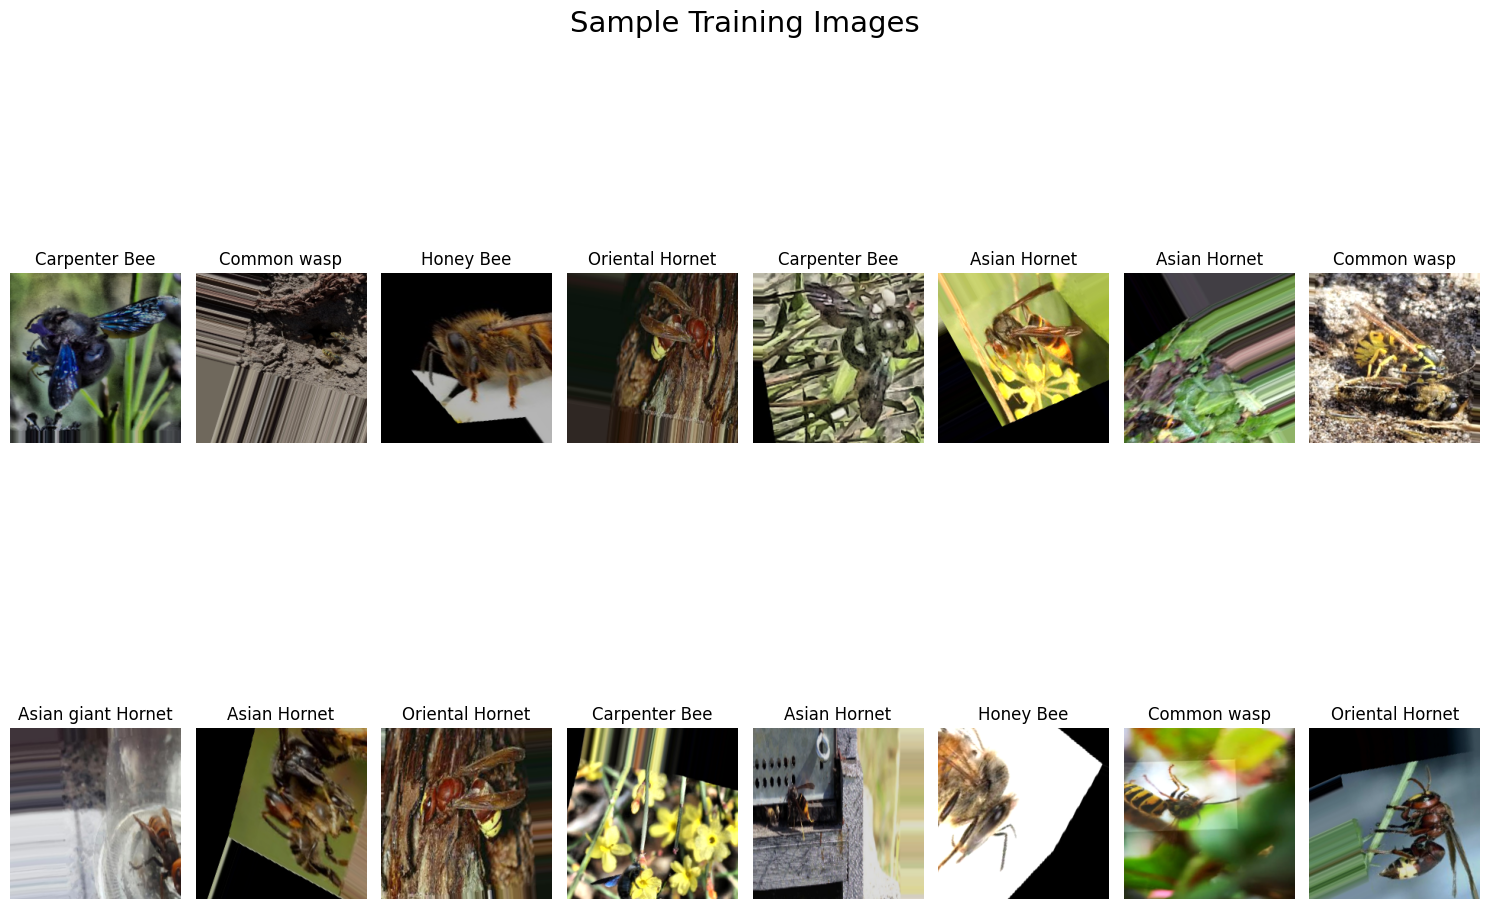

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 220, 220, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 220, 220, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 110, 110, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 110, 110, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 108, 108, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 108, 108, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       5,538,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,642,984 (21.53 MB)

 Trainable params: 5,642,536 (21.52 MB)

 Non-trainable params: 448 (1.75 KB)

None
Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 3429s 19s/step - accuracy: 0.2271 - loss: 8.5024 - val_accuracy: 0.1613 - val_loss: 2.7994 - learning_rate: 0.0010
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 139s 776ms/step - accuracy: 0.2668 - loss: 3.2592 - val_accuracy: 0.1822 - val_loss: 2.1229 - learning_rate: 0.0010
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 779ms/step - accuracy: 0.2964 - loss: 1.9107 - val_accuracy: 0.3238 - val_loss: 1.7608 - learning_rate: 0.0010
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 152s 855ms/step - accuracy: 0.3123 - loss: 1.7740 - val_accuracy: 0.3650 - val_loss: 1.6427 - learning_rate: 0.0010
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 780ms/step - accuracy: 0.3313 - loss: 1.7490 - val_accuracy: 0.4162 - val_loss: 1.5751 - learning_rate: 0.0010
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 142s 792ms/step - accuracy: 0.3551 - loss: 1.7012 - val_accuracy: 0.4118 - val_loss: 1.6883 - learning_rate: 0.0010
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 150s 834ms/step - ac

KeyError: 'lr'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
import shutil
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define directories (already existing on your drive)
base_dir = '/content/drive/MyDrive/Insect Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=30,
    brightness_range=[0.7, 1.3],
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                             target_size=(224, 224),
                                                             batch_size=32,
                                                             class_mode='categorical',
                                                             shuffle=True)

# Labels mapping
labels = {value: key for key, value in train_generator.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

# Sample images
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(8):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# Model creation
def create_model():
    return Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=8, activation='softmax')
    ])

cnn_model = create_model()
print(cnn_model.summary())

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Compile the model
optimizer = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Save the model
cnn_model.save('High_augmentation.keras')

# Plot training results with plain lines (no markers)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))
ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, label='Train Accuracy', color='blue', linestyle='-')
ax[0].plot(val_accuracy, label='Validation Accuracy', color='green', linestyle='-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, label='Train Loss', color='blue', linestyle='-')
ax[1].plot(val_loss, label='Validation Loss', color='green', linestyle='-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, label='Learning Rate', color='red', linestyle='-')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Learning Rate')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

# Test data preparation
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_generator, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = cnn_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Found 797 images belonging to 8 classes.
25/25 - 398s - 16s/step - accuracy: 0.7415 - loss: 0.7285
Test Loss: 0.7285475730895996
Test Accuracy: 0.74153071641922
25/25 - 6s - 232ms/step
Classification Report:
                     precision    recall  f1-score   support

      Asian Hornet       0.81      0.61      0.70       101
Asian giant Hornet       0.60      0.85      0.70        98
     Carpenter Bee       0.92      0.97      0.94       101
       Common wasp       0.57      0.57      0.57       101
   European hornet       0.77      0.75      0.76       101
         Honey Bee       0.86      0.71      0.78        93
          Hoverfly       0.57      0.55      0.56       101
   Oriental Hornet       0.94      0.91      0.92       101

          accuracy                           0.74       797
         macro avg       0.75      0.74      0.74       797
      weighted avg       0.75      0.74      0.74       797



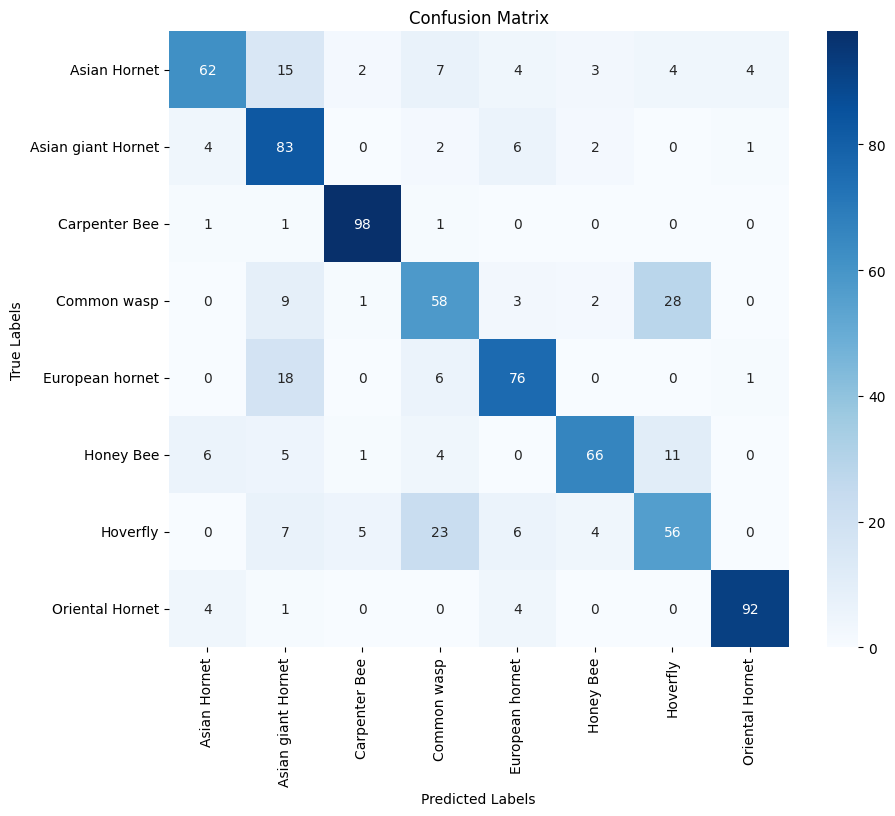

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained model
cnn_model = load_model('best_model.keras')

# Define directories (already existing on your drive)
base_dir = '/content/drive/MyDrive/Insect Dataset'
test_dir = os.path.join(base_dir, 'test')

# Test data preparation
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_generator, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = cnn_model.predict(test_generator, verbose=2)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


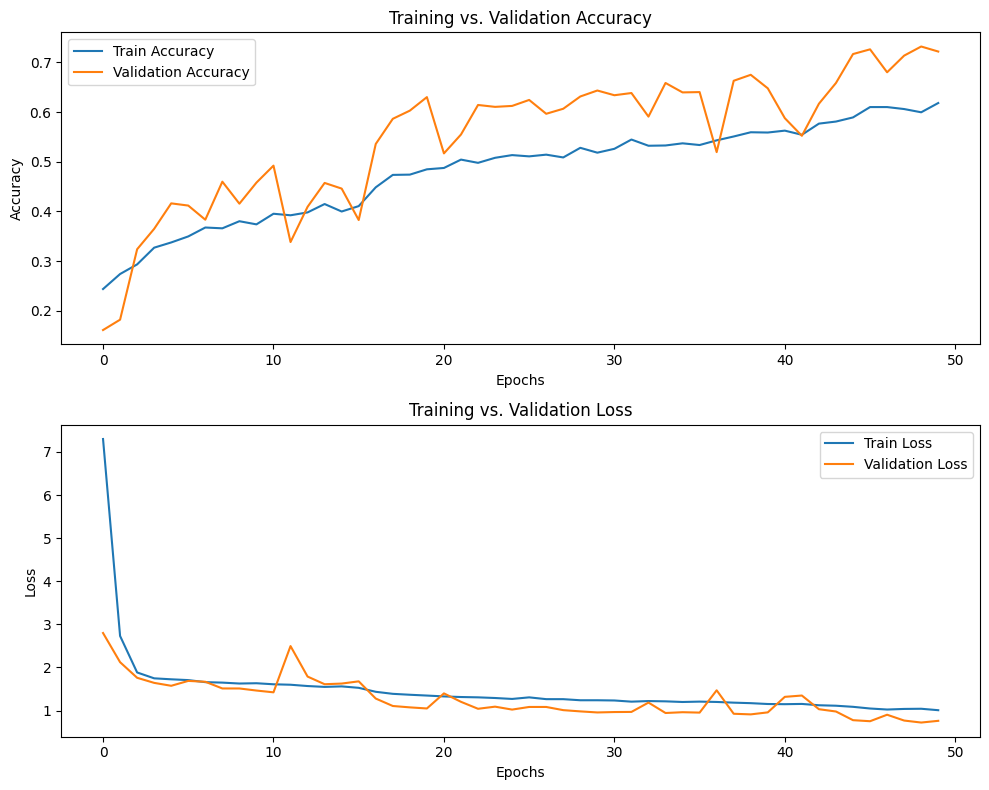

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model
model = load_model('best_model.keras')

# Assuming you have already loaded the history from your previous training
# Plot training results
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Accuracy plot
ax[0].set_title('Training vs. Validation Accuracy')
ax[0].plot(train_accuracy, label='Train Accuracy', linestyle='-')
ax[0].plot(val_accuracy, label='Validation Accuracy', linestyle='-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

# Loss plot
ax[1].set_title('Training vs. Validation Loss')
ax[1].plot(train_loss, label='Train Loss', linestyle='-')
ax[1].plot(val_loss, label='Validation Loss', linestyle='-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()


In [ ]:
# Print final training and validation accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Final Training Accuracy: 61.81%
Final Validation Accuracy: 72.17%
Test Accuracy: 74.15%


## CNN with Moderate Augmentation range and excluded the shear range parameter. (Augmentation version 2)

Found 5525 images belonging to 8 classes.
Found 1581 images belonging to 8 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 220, 220, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 220, 220, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 110, 110, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 110, 110, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 108, 108, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 108, 108, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       5,538,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,642,984 (21.53 MB)

 Trainable params: 5,642,536 (21.52 MB)

 Non-trainable params: 448 (1.75 KB)

None
Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 164s 825ms/step - accuracy: 0.2428 - loss: 7.2249 - val_accuracy: 0.1366 - val_loss: 4.3200 - learning_rate: 0.0010
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 177s 765ms/step - accuracy: 0.3132 - loss: 2.8241 - val_accuracy: 0.1676 - val_loss: 3.2009 - learning_rate: 0.0010
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 123s 686ms/step - accuracy: 0.3232 - loss: 1.8715 - val_accuracy: 0.3637 - val_loss: 1.7168 - learning_rate: 0.0010
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 134s 746ms/step - accuracy: 0.3476 - loss: 1.7151 - val_accuracy: 0.3574 - val_loss: 1.5823 - learning_rate: 0.0010
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 143s 799ms/step - accuracy: 0.3745 - loss: 1.6273 - val_accuracy: 0.5016 - val_loss: 1.3528 - learning_rate: 0.0010
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 147s 829ms/step - accuracy: 0.4051 - loss: 1.5550 - val_accuracy: 0.4503 - val_loss: 1.5007 - learning_rate: 0.0010
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 177s 673ms/step - a

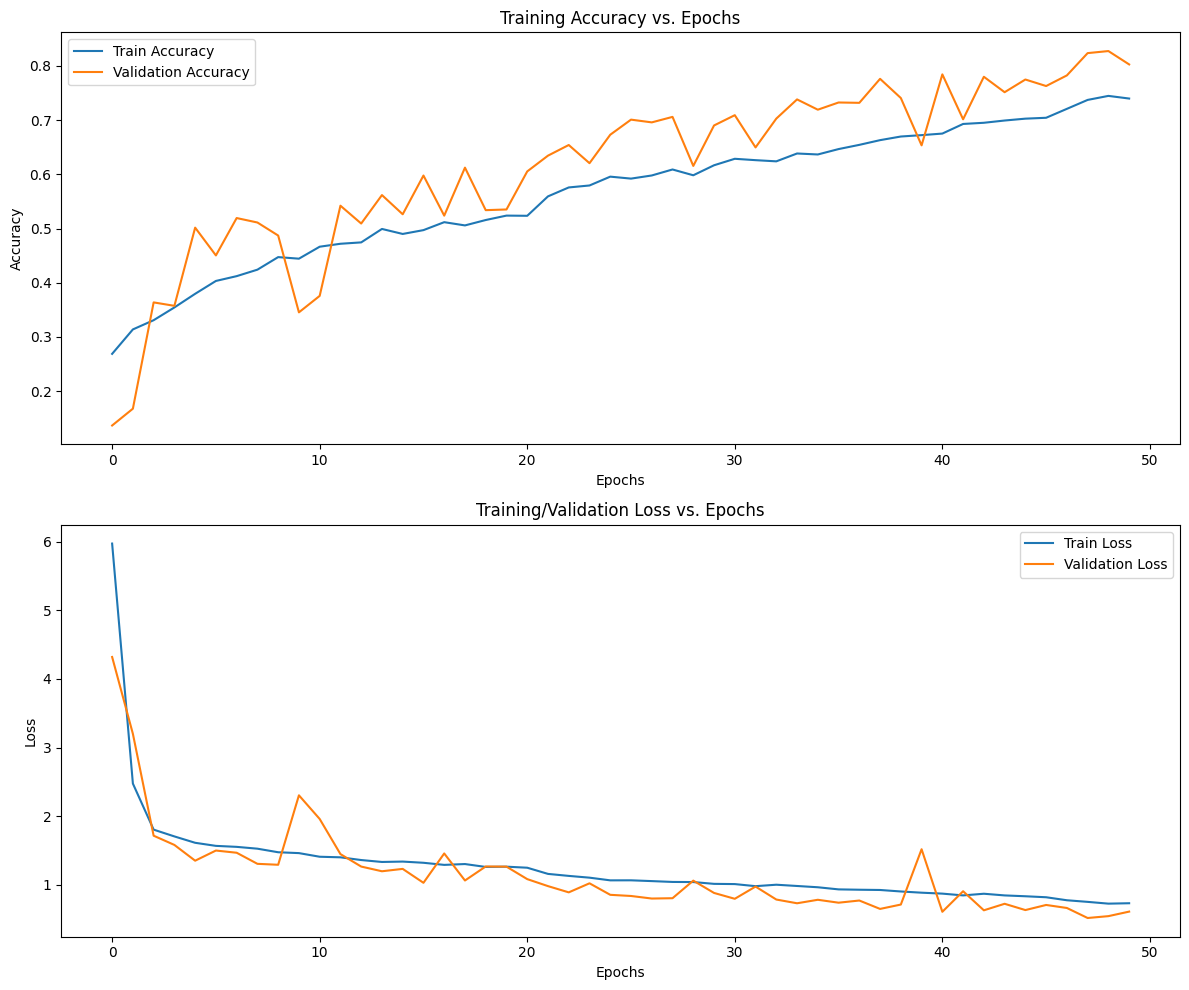

TypeError: ImageDataGenerator.flow_from_directory() got an unexpected keyword argument 'verbose'

In [ ]:
%matplotlib inline

import cv2
import os
import shutil
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Define directories
base_dir = '/content/drive/MyDrive/Insect Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create train, validation, and test directories
for category in os.listdir(base_dir):
    if category not in ['train', 'val', 'test']:
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Split data into train, validation, and test sets
def split_data(base_dir, train_dir, val_dir, test_dir, val_size=0.2, test_size=0.1):
    for category in os.listdir(base_dir):
        if category not in ['train', 'val', 'test']:
            category_path = os.path.join(base_dir, category)
            images = os.listdir(category_path)
            train_images, temp_images = train_test_split(images, test_size=(val_size + test_size), random_state=42)
            val_images, test_images = train_test_split(temp_images, test_size=(test_size / (val_size + test_size)), random_state=42)

            for img in train_images:
                shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))
            for img in val_images:
                shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))
            for img in test_images:
                shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category, img))

# Split the data
split_data(base_dir, train_dir, val_dir, test_dir)
##
# Image Data Generator
train_datagen = ImageDataGenerator(rescale=1.0/255, zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, rotation_range=20,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest',
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                             target_size=(224, 224),
                                                             batch_size=32,
                                                             class_mode='categorical',
                                                             shuffle=True)

# Model creation
def create_model():
    return Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=8, activation='softmax')
    ])

cnn_model = create_model()
print(cnn_model.summary())

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('Moderate_augmentation.keras', monitor='val_loss', save_best_only=True)

# Compile the model
optimizer = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Save the model
cnn_model.save('final_model.keras')

# Plot training results
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, '-', label='Train Accuracy')
ax[0].plot(val_accuracy, '-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, '-', label='Train Loss')
ax[1].plot(val_loss, '-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test data preparation
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_generator, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = cnn_model.predict(test_generator, verbose=2)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print final training and validation accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 797 images belonging to 8 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.7913 - loss: 0.6053
Test Loss: 0.5628459453582764
Test Accuracy: 0.8042659759521484
25/25 - 6s - 241ms/step
Classification Report:
                      precision    recall  f1-score   support

       Asian Hornet       0.90      0.72      0.80       101
Asian giant Hornet        0.85      0.84      0.85        98
      Carpenter Bee       0.94      0.97      0.96       101
        Common wasp       0.66      0.62      0.64       101
    European hornet       0.78      0.89      0.83       101
          Honey Bee       0.74      0.86      0.80        93
           Hoverfly       0.59      0.57      0.58       101
    Oriental Hornet       0.98      0.96      0.97       101

           accuracy                           0.80       797
          macro avg       0.81      0.80      0.80       797
       weighted avg       0.81      0.80      0.80       797



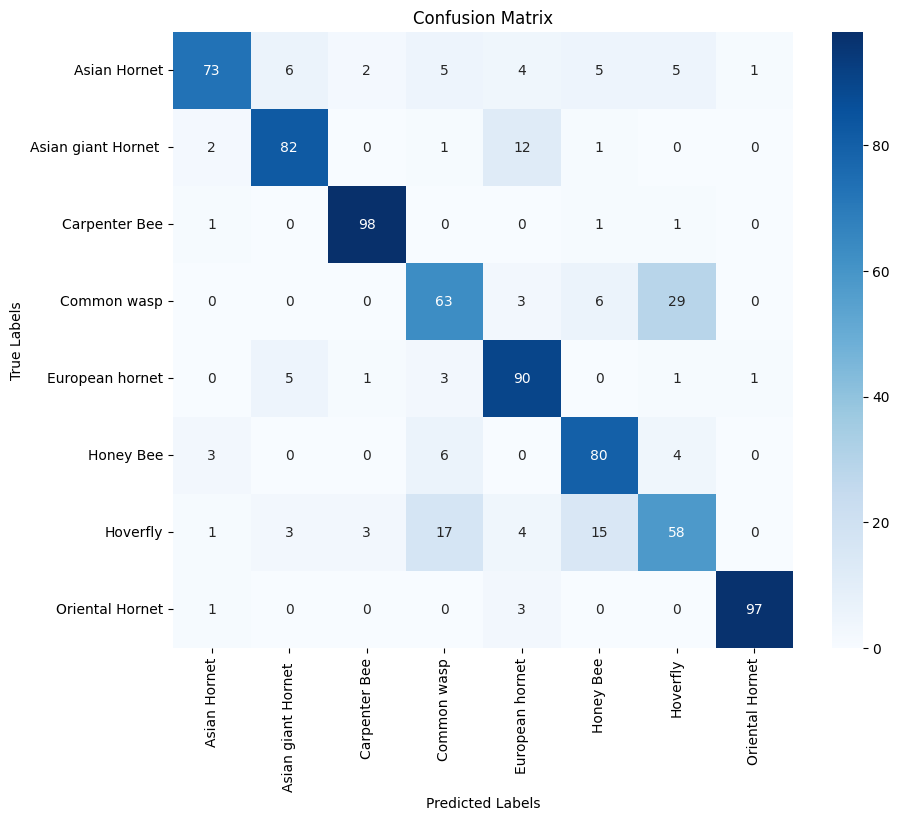

Final Training Accuracy: 73.97%
Final Validation Accuracy: 80.27%
Test Accuracy: 80.43%


In [ ]:

from tensorflow.keras.models import load_model# Load the model
model = load_model('Moderate_augmentation.keras')
# Test data preparation
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)
# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = cnn_model.predict(test_generator, verbose=2)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print final training and validation accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


## Version 3.

Found 5525 images belonging to 8 classes.
Found 1581 images belonging to 8 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 224, 224, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 224, 224, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 56, 56, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,825,992 (26.04 MB)

 Trainable params: 6,825,224 (26.04 MB)

 Non-trainable params: 768 (3.00 KB)

None
Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 160s 807ms/step - accuracy: 0.2186 - loss: 2.9846 - val_accuracy: 0.1581 - val_loss: 2.5306 - learning_rate: 1.0000e-04
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 119s 664ms/step - accuracy: 0.3084 - loss: 2.0792 - val_accuracy: 0.1335 - val_loss: 2.8150 - learning_rate: 1.0000e-04
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 123s 678ms/step - accuracy: 0.3341 - loss: 1.8872 - val_accuracy: 0.4023 - val_loss: 1.6589 - learning_rate: 1.0000e-04
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 145s 694ms/step - accuracy: 0.3712 - loss: 1.7550 - val_accuracy: 0.5016 - val_loss: 1.4605 - learning_rate: 1.0000e-04
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 139s 679ms/step - accuracy: 0.3888 - loss: 1.7248 - val_accuracy: 0.4946 - val_loss: 1.4509 - learning_rate: 1.0000e-04
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 120s 673ms/step - accuracy: 0.4022 - loss: 1.7022 - val_accuracy: 0.5509 - val_loss: 1.3130 - learning_rate: 1.0000e-04
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━

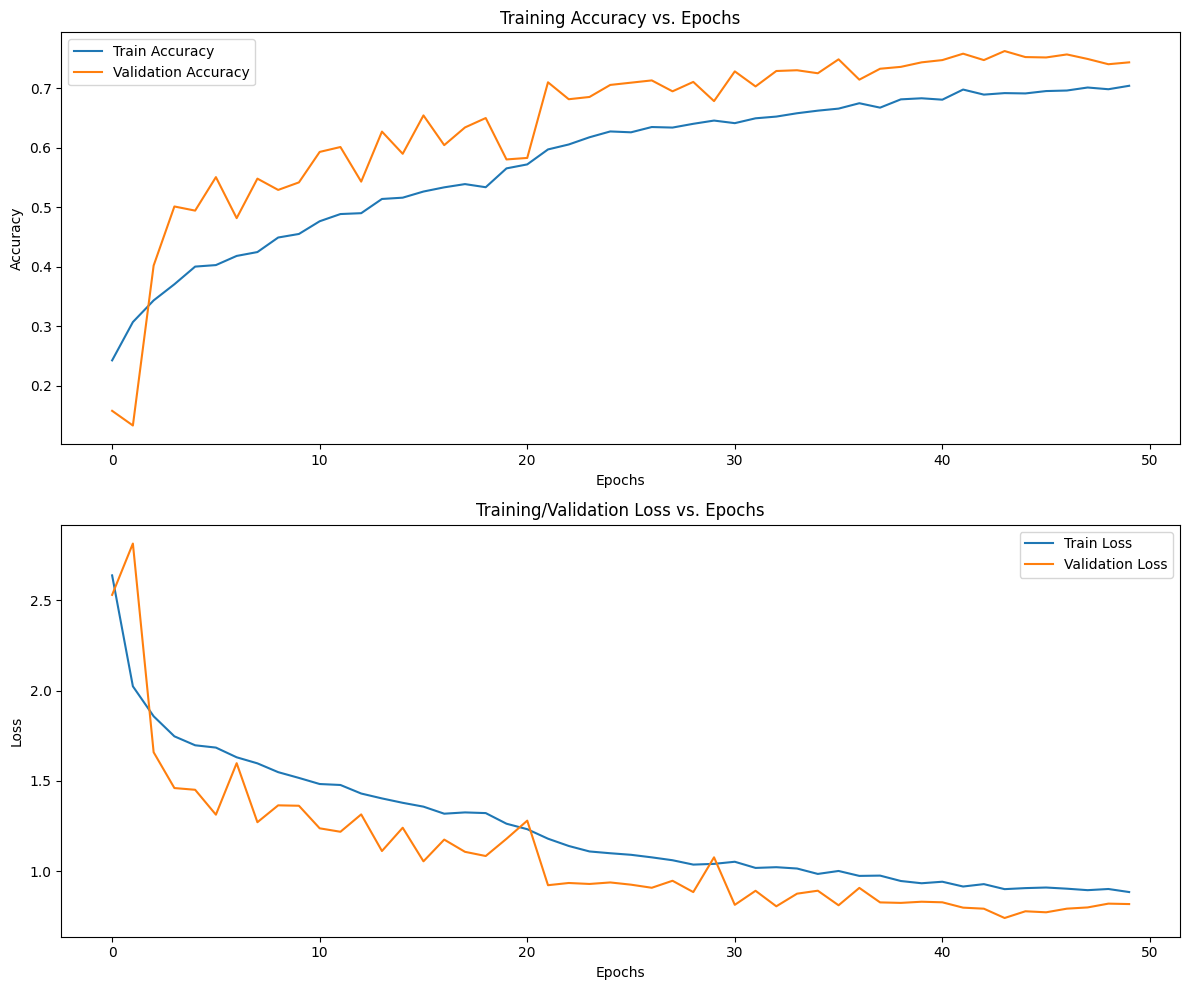

Found 797 images belonging to 8 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step - accuracy: 0.7673 - loss: 0.8453
Test Loss: 0.7893835306167603
Test Accuracy: 0.760351300239563
25/25 - 5s - 211ms/step
Classification Report:
                      precision    recall  f1-score   support

       Asian Hornet       0.91      0.71      0.80       101
Asian giant Hornet        0.70      0.80      0.75        98
      Carpenter Bee       0.82      0.97      0.89       101
        Common wasp       0.53      0.78      0.63       101
    European hornet       0.83      0.67      0.74       101
          Honey Bee       0.81      0.76      0.78        93
           Hoverfly       0.65      0.44      0.52       101
    Oriental Hornet       0.96      0.95      0.96       101

           accuracy                           0.76       797
          macro avg       0.78      0.76      0.76       797
       weighted avg       0.78      0.76      0.76       797



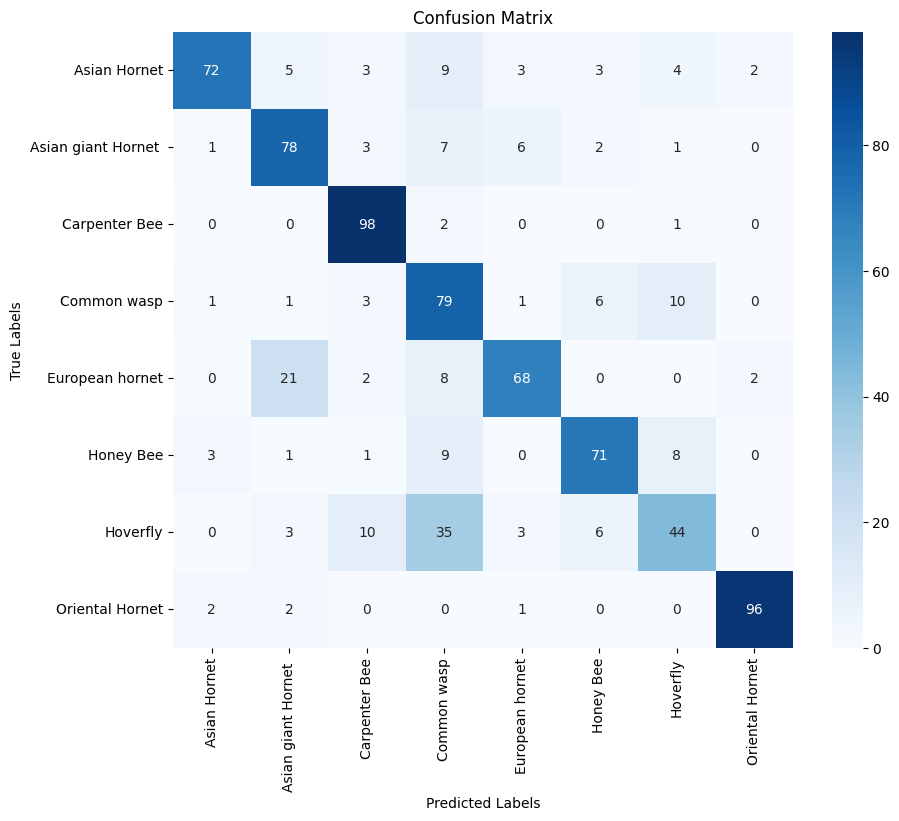

Final Training Accuracy: 70.44%
Final Validation Accuracy: 74.38%
Test Accuracy: 76.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
import shutil
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define directories
base_dir = '/content/drive/MyDrive/Insect Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image Data Generator
train_datagen = ImageDataGenerator( rescale=1.0/255, zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, rotation_range=20,
                                    brightness_range=[0.8, 1.2],
                                    fill_mode='nearest',
                                    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                             target_size=(224, 224),
                                                             batch_size=32,
                                                             class_mode='categorical',
                                                             shuffle=True)


# Model creation
def create_model():
    return Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='same', input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(units=512, activation='relu', kernel_regularizer=l2(0.00005)),
        Dropout(0.5),
        Dense(units=256, activation='relu', kernel_regularizer=l2(0.00005)),
        Dropout(0.5),
        Dense(units=8, activation='softmax')
    ])

cnn_model = create_model()
print(cnn_model.summary())

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('Version_3.keras', monitor='val_loss', save_best_only=True)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Save the model
cnn_model.save('final_model.keras')

# Plot training results
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, '-', label='Train Accuracy')
ax[0].plot(val_accuracy, '-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, '-', label='Train Loss')
ax[1].plot(val_loss, '-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test data preparation
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = cnn_model.predict(test_generator, verbose=2)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print final training and validation accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

## Version 4.

Found 5525 images belonging to 8 classes.
Found 1581 images belonging to 8 classes.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 224, 224, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 224, 224, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 56, 56, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,825,992 (26.04 MB)

 Trainable params: 6,825,224 (26.04 MB)

 Non-trainable params: 768 (3.00 KB)

None
Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 135s 710ms/step - accuracy: 0.1895 - loss: 5.8487 - val_accuracy: 0.1505 - val_loss: 4.1194 - learning_rate: 0.0010
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 129s 661ms/step - accuracy: 0.2729 - loss: 3.8396 - val_accuracy: 0.2517 - val_loss: 3.6582 - learning_rate: 0.0010
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 119s 668ms/step - accuracy: 0.3179 - loss: 3.5042 - val_accuracy: 0.3795 - val_loss: 3.2381 - learning_rate: 0.0010
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 143s 675ms/step - accuracy: 0.3392 - loss: 3.2294 - val_accuracy: 0.4156 - val_loss: 2.9996 - learning_rate: 0.0010
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 121s 674ms/step - accuracy: 0.3642 - loss: 3.0201 - val_accuracy: 0.4497 - val_loss: 2.7183 - learning_rate: 0.0010
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 673ms/step - accuracy: 0.3719 - loss: 2.8307 - val_accuracy: 0.5054 - val_loss: 2.4931 - learning_rate: 0.0010
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 121s 676ms/step - a

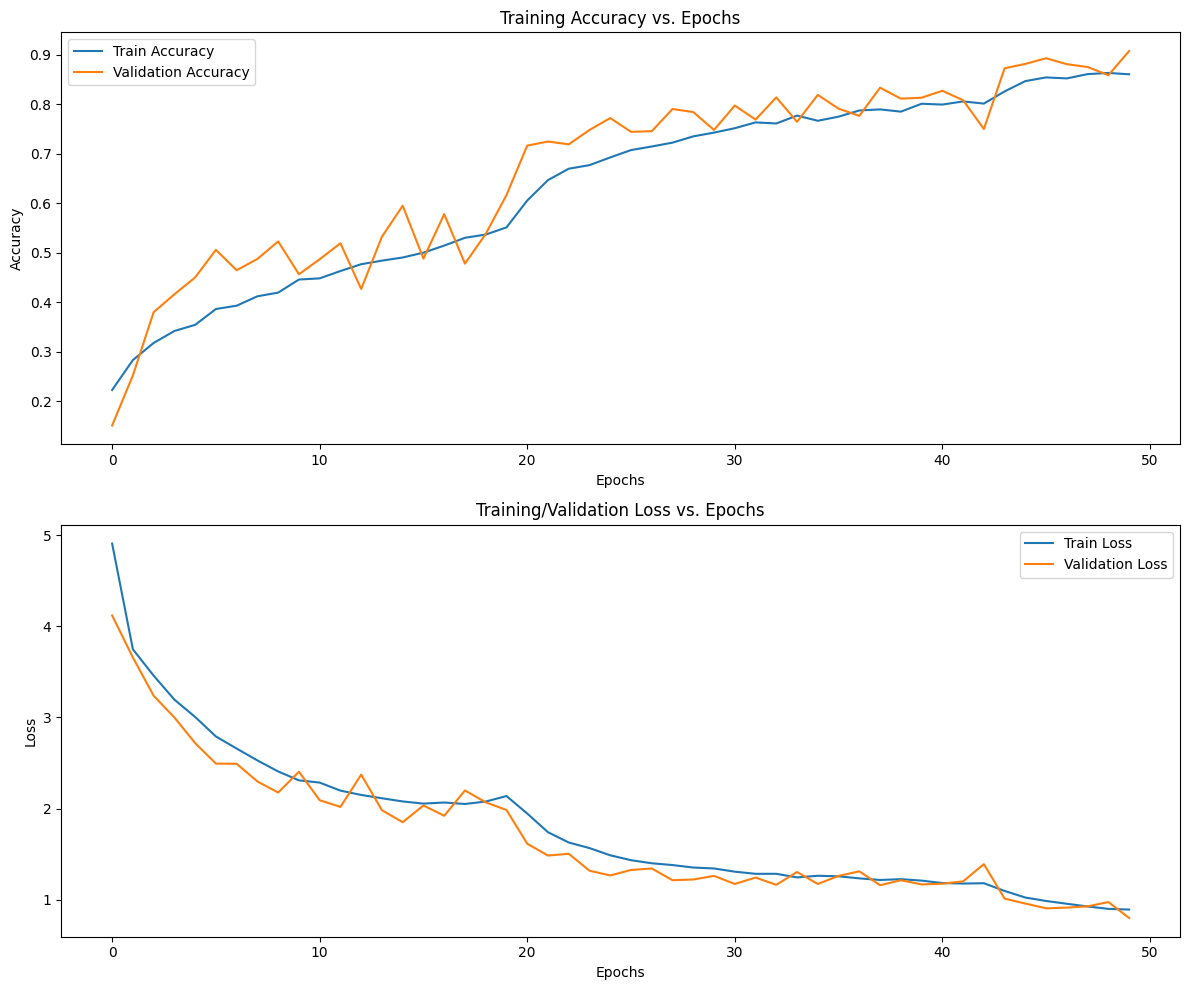

Found 797 images belonging to 8 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.8884 - loss: 0.8167
Test Loss: 0.8653051257133484
Test Accuracy: 0.8632371425628662
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step
Classification Report:
                      precision    recall  f1-score   support

       Asian Hornet       0.91      0.88      0.89       101
Asian giant Hornet        0.90      0.98      0.94        98
      Carpenter Bee       0.92      0.98      0.95       101
        Common wasp       0.79      0.68      0.73       101
    European hornet       0.92      0.92      0.92       101
          Honey Bee       0.87      0.86      0.86        93
           Hoverfly       0.61      0.61      0.61       101
    Oriental Hornet       0.97      0.99      0.98       101

           accuracy                           0.86       797
          macro avg       0.86      0.86      0.86       797
       weighted avg       0.86      0.86      0.86       797



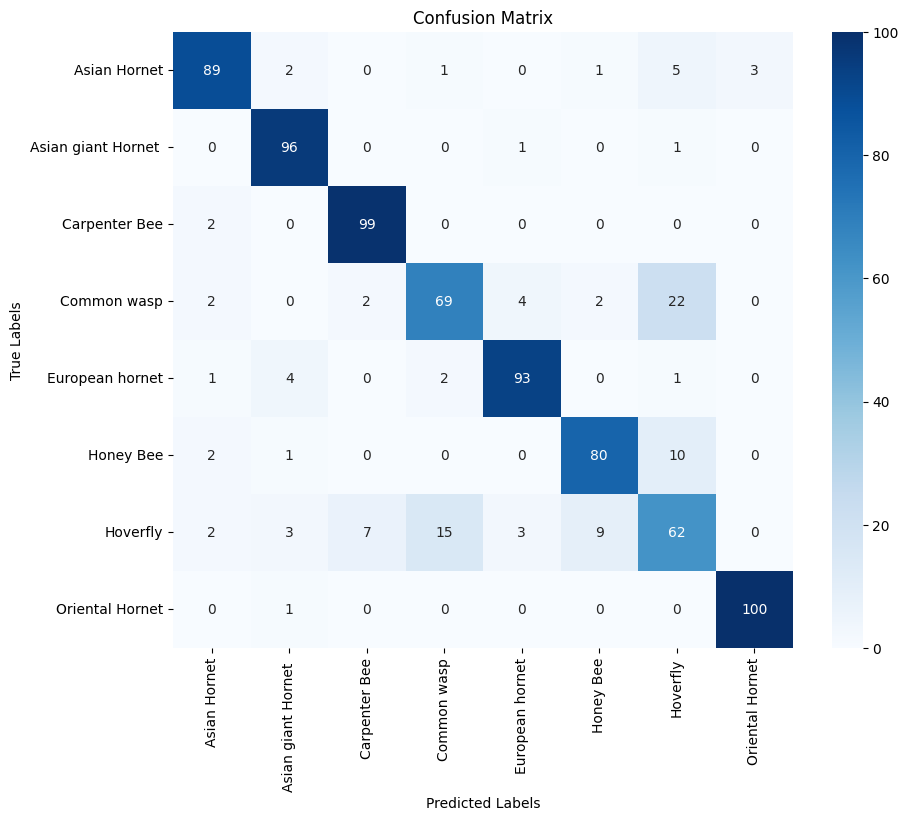

Final Training Accuracy: 86.01%
Final Validation Accuracy: 90.70%
Test Accuracy: 86.32%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
import shutil
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define directories
base_dir = '/content/drive/MyDrive/Insect Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image Data Generator
train_datagen = ImageDataGenerator( rescale=1.0/255, zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, rotation_range=20,
                                    brightness_range=[0.8, 1.2],
                                    fill_mode='nearest',
                                    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                             target_size=(224, 224),
                                                             batch_size=32,
                                                             class_mode='categorical',
                                                             shuffle=True)


# Model creation
def create_model():
    return Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='same', input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(units=512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(units=8, activation='softmax')
    ])

cnn_model = create_model()
print(cnn_model.summary())

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('Version_4.keras', monitor='val_loss', save_best_only=True)

# Compile the model
optimizer = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Save the model
cnn_model.save('final_model.keras')

# Plot training results
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, '-', label='Train Accuracy')
ax[0].plot(val_accuracy, '-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, '-', label='Train Loss')
ax[1].plot(val_loss, '-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test data preparation
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = cnn_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print final training and validation accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

## Version 5.

Found 5525 images belonging to 8 classes.
Found 1581 images belonging to 8 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,825,992 (26.04 MB)

 Trainable params: 6,825,224 (26.04 MB)

 Non-trainable params: 768 (3.00 KB)

None
Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1563s 17s/step - accuracy: 0.2085 - loss: 5.4692 - val_accuracy: 0.1448 - val_loss: 3.9605 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.2766 - loss: 3.8629 - val_accuracy: 0.1354 - val_loss: 4.0317 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.3060 - loss: 3.5935 - val_accuracy: 0.2030 - val_loss: 3.7050 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.3363 - loss: 3.3980 - val_accuracy: 0.2043 - val_loss: 3.5862 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.3415 - loss: 3.2391 - val_accuracy: 0.3618 - val_loss: 3.1951 - learning_rate: 0.0010
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3789 - loss: 3.0719 - val_accuracy: 0.4048 - val_loss: 2.8900 - learning_rate: 0.0010
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3915 - loss: 2.9258 - 

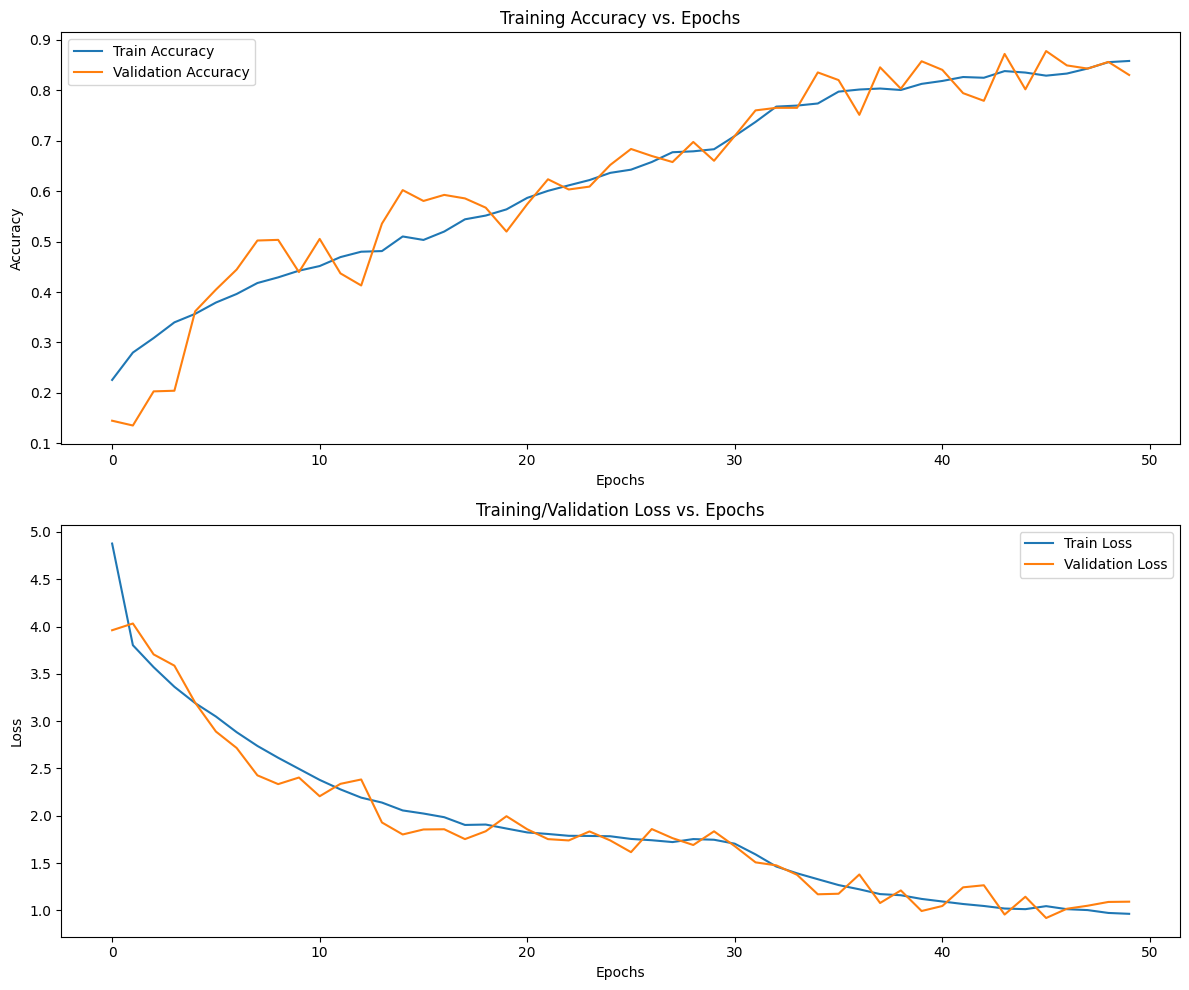

Found 797 images belonging to 8 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 152s 13s/step - accuracy: 0.8677 - loss: 0.9679
Test Loss: 0.9874154329299927
Test Accuracy: 0.8506900668144226
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 428ms/step
Classification Report:
                      precision    recall  f1-score   support

       Asian Hornet       0.85      0.88      0.86       101
Asian giant Hornet        0.87      0.95      0.91        98
      Carpenter Bee       0.95      0.94      0.95       101
        Common wasp       0.77      0.66      0.71       101
    European hornet       0.89      0.91      0.90       101
          Honey Bee       0.93      0.76      0.84        93
           Hoverfly       0.61      0.73      0.67       101
    Oriental Hornet       0.99      0.96      0.97       101

           accuracy                           0.85       797
          macro avg       0.86      0.85      0.85       797
       weighted avg       0.86      0.85      0.85       797



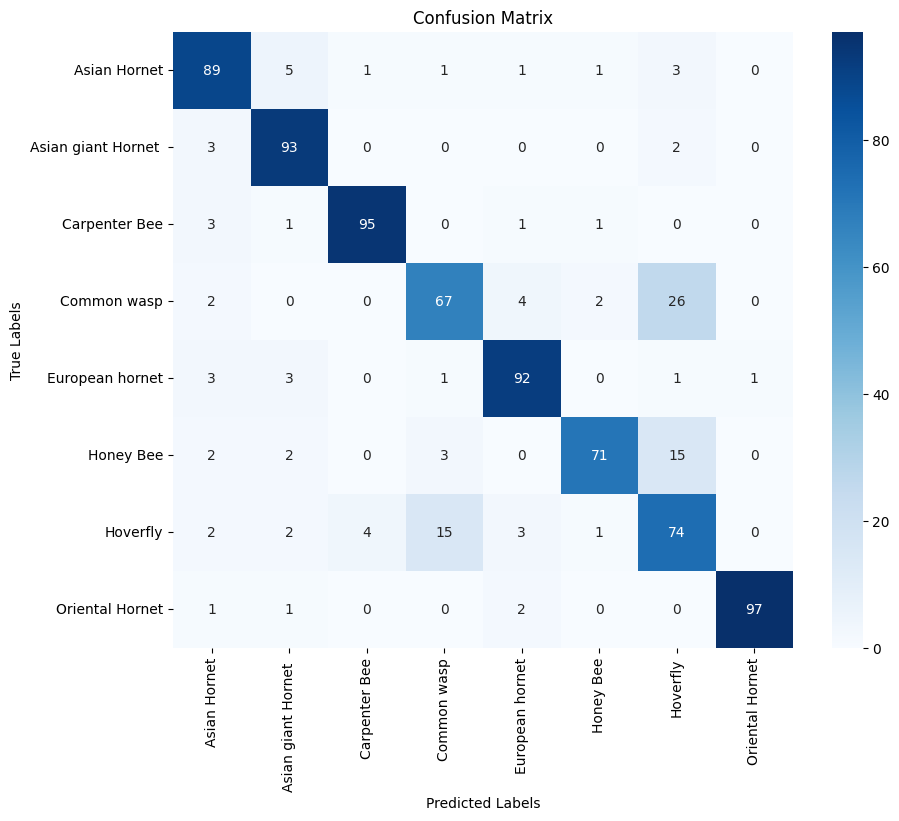

Final Training Accuracy: 85.83%
Final Validation Accuracy: 83.05%
Test Accuracy: 85.07%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
import shutil
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define directories
base_dir = '/content/drive/MyDrive/Insect Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image Data Generator
train_datagen = ImageDataGenerator( rescale=1.0/255, zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, rotation_range=20,
                                    brightness_range=[0.8, 1.2],
                                    fill_mode='nearest',
                                    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=64,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                             target_size=(224, 224),
                                                             batch_size=64,
                                                             class_mode='categorical',
                                                             shuffle=True)


# Model creation
def create_model():
    return Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='same', input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(units=512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(units=8, activation='softmax')
    ])

cnn_model = create_model()
print(cnn_model.summary())

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('Version_5.keras', monitor='val_loss', save_best_only=True)

# Compile the model
optimizer = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Save the model
cnn_model.save('final_model.keras')

# Plot training results
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, '-', label='Train Accuracy')
ax[0].plot(val_accuracy, '-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, '-', label='Train Loss')
ax[1].plot(val_loss, '-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test data preparation
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = cnn_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print final training and validation accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

## Stratified K-fold Validation Analysis on Version 5.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define directories
base_dir = '/content/drive/MyDrive/Insect Dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Image Data Generator
train_datagen = ImageDataGenerator(rescale=1.0/255, zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, rotation_range=20,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest',
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=64,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(test_dir,
                                                             target_size=(224, 224),
                                                             batch_size=64,
                                                             class_mode='categorical',
                                                             shuffle=True)

# Labels mapping
labels = {value: key for key, value in train_generator.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

# Model creation function
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='same', input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(units=512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(units=8, activation='softmax')
    ])
    return model

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
losses = []

for train_idx, val_idx in skf.split(train_generator.filenames, train_generator.classes):
    print(f'Processing fold {fold_no}...')

    # Model creation
    cnn_model = create_model()

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'model_fold_{fold_no}.keras', monitor='val_loss', save_best_only=True)

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

    # Train the model
    history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                           verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

    # Save the model after each fold
    cnn_model.save(f'model_fold_{fold_no}.keras')
    print(f"Model for Fold {fold_no} saved as model_fold_{fold_no}.keras")

    # Evaluate the model on the validation data
    val_loss, val_accuracy = cnn_model.evaluate(validation_generator, verbose=1)
    accuracies.append(val_accuracy)
    losses.append(val_loss)

    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_accuracy}")

    # Increment the fold number
    fold_no += 1

# Final model save
cnn_model.save('final_model.keras')
print("Final model saved as final_model.keras")

# Calculate statistics for accuracies
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
var_acc = np.var(accuracies)

print("\nK-Fold Cross-Validation Results:")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Standard Deviation: {std_acc:.4f}")
print(f"Variance: {var_acc:.4f}")

# Test Accuracy (final fold)
test_loss, test_accuracy = cnn_model.evaluate(validation_generator, verbose=1)
print(f"\nFinal Test Accuracy: {test_accuracy * 100:.2f}%")

# Plotting code
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, '-', label='Train Accuracy')
ax[0].plot(val_accuracy, '-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, '-', label='Train Loss')
ax[1].plot(val_loss, '-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Download the saved models for each fold
from google.colab import files
for i in range(1, fold_no):
    files.download(f'model_fold_{i}.keras')
files.download('final_model.keras')


Found 5525 images belonging to 8 classes.
Found 797 images belonging to 8 classes.
Label Mappings for classes present in the training and validation datasets

0 : Asian Hornet
1 : Asian giant Hornet 
2 : Carpenter Bee
3 : Common wasp
4 : European hornet
5 : Honey Bee
6 : Hoverfly
7 : Oriental Hornet
Processing fold 1...
Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2572s 27s/step - accuracy: 0.2262 - loss: 5.3271 - val_accuracy: 0.1380 - val_loss: 3.9610 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.2768 - loss: 3.8605 - val_accuracy: 0.1468 - val_loss: 3.9660 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.3069 - loss: 3.6151 - val_accuracy: 0.1593 - val_loss: 3.8447 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3308 - loss: 3.4451 - val_accuracy: 0.2698 - val_loss: 3.5230 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.3638 - 

# Transfer Learning with Pretrained Models

## VGG16

Found 5525 images belonging to 8 classes.
Found 1581 images belonging to 8 classes.
Label Mappings for classes present in the training and validation datasets

0 : Asian Hornet
1 : Asian giant Hornet 
2 : Carpenter Bee
3 : Common wasp
4 : European hornet
5 : Honey Bee
6 : Hoverfly
7 : Oriental Hornet


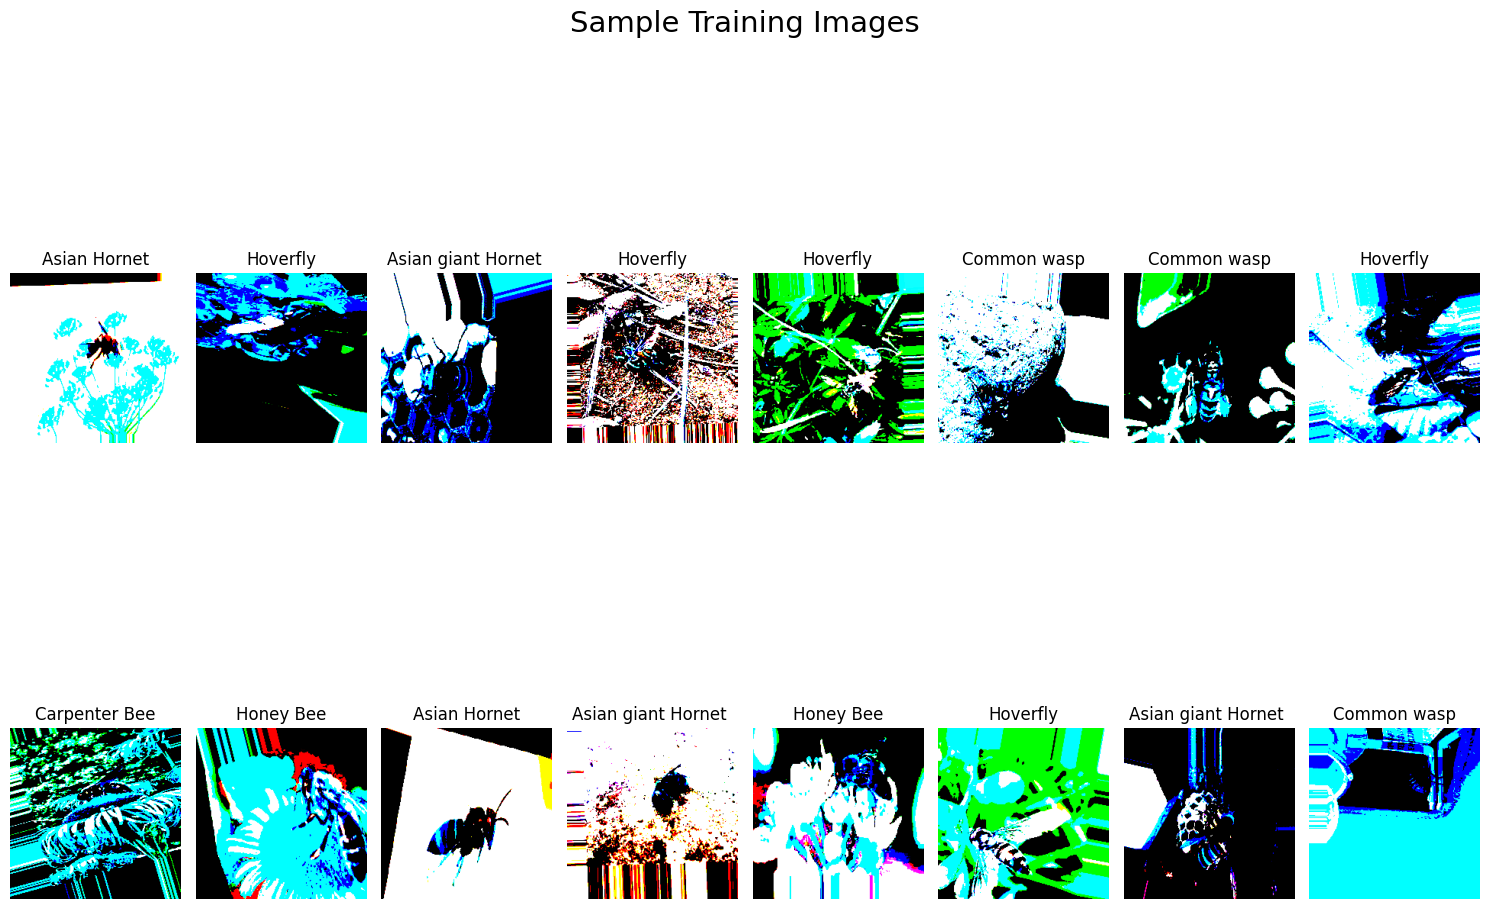

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,6

 Total params: 14,781,384 (56.39 MB)

 Trainable params: 14,781,384 (56.39 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2063s 22s/step - accuracy: 0.1329 - loss: 7.6987 - val_accuracy: 0.1069 - val_loss: 2.0768 - learning_rate: 0.0010
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.1202 - loss: 2.0855 - val_accuracy: 0.1436 - val_loss: 2.0646 - learning_rate: 0.0010
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.1523 - loss: 2.0585 - val_accuracy: 0.1872 - val_loss: 2.0025 - learning_rate: 0.0010
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.2112 - loss: 1.9829 - val_accuracy: 0.2606 - val_loss: 1.8969 - learning_rate: 0.0010
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.2152 - loss: 1.9451 - val_accuracy: 0.2517 - val_loss: 1.8797 - learning_rate: 0.0010
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.2533 - loss: 1.8835 - val_accuracy: 0.2707 - val_loss: 1.8343 - learning_rate: 0.0010
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.2532 - loss: 1.

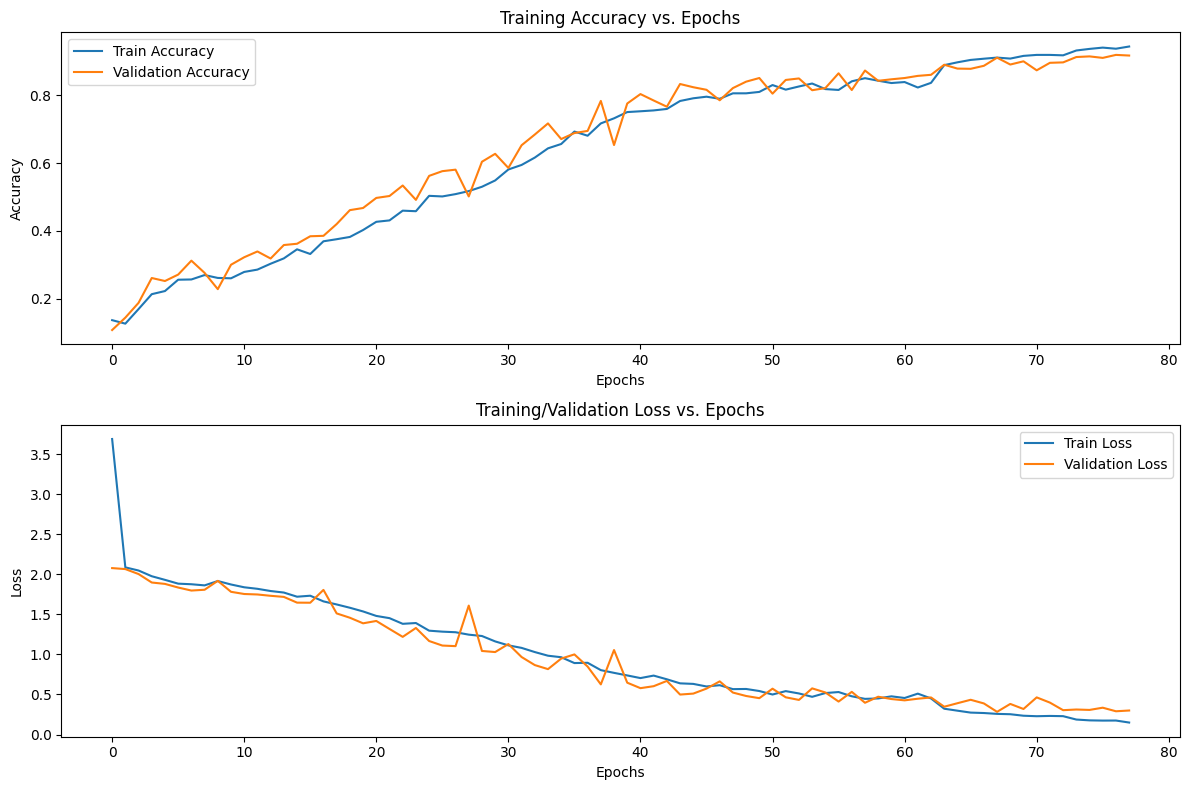

Found 797 images belonging to 8 classes.
13/13 - 268s - 21s/step - accuracy: 0.8808 - loss: 0.4074
Test Loss: 0.40742287039756775
Test Accuracy: 0.8808029890060425
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step
Classification Report:
                      precision    recall  f1-score   support

       Asian Hornet       0.91      0.82      0.86       101
Asian giant Hornet        0.89      0.95      0.92        98
      Carpenter Bee       0.94      0.97      0.96       101
        Common wasp       0.81      0.79      0.80       101
    European hornet       0.91      0.95      0.93       101
          Honey Bee       0.92      0.87      0.90        93
           Hoverfly       0.69      0.72      0.71       101
    Oriental Hornet       0.99      0.97      0.98       101

           accuracy                           0.88       797
          macro avg       0.88      0.88      0.88       797
       weighted avg       0.88      0.88      0.88       797



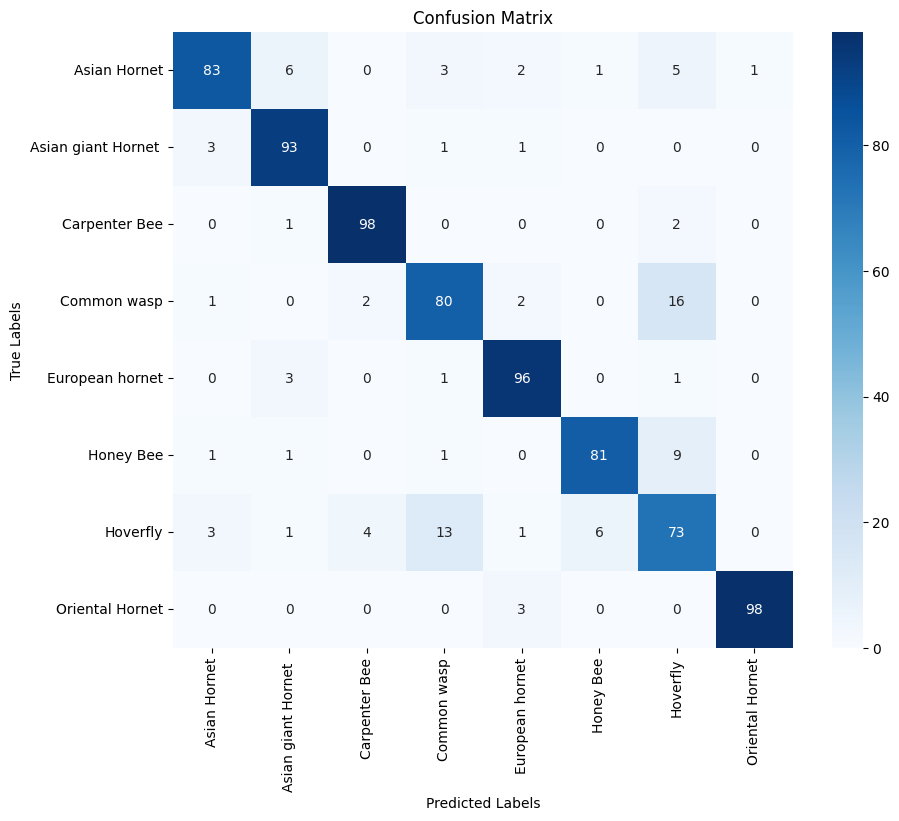

Final Training Accuracy: 94.44%
Final Validation Accuracy: 91.78%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Define directories
base_dir ='/content/drive/MyDrive/Insect Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image Data Generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, rotation_range=20,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest',
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=64,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                             target_size=(224, 224),
                                                             batch_size=64,
                                                             class_mode='categorical',
                                                             shuffle=True)

# Labels mapping
labels = {value: key for key, value in train_generator.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

# Sample images
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(8):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# Model creation using VGG16
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=8):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze all layers of the base model
    for layer in base_model.layers:
        layer.trainable = True

    # Adding custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Create and summarize the model
vgg16_model = create_vgg16_model()
print(vgg16_model.summary())

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('VGG16.keras', monitor='val_loss', save_best_only=True)

# Compile the model
optimizer = Adam(learning_rate=0.001)
vgg16_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the VGG16 model
history = vgg16_model.fit(train_generator, epochs=100, validation_data=validation_generator,
                          verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Save the trained model
vgg16_model.save('final_VGG16.keras')

# Plot training results
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, '-', label='Train Accuracy')
ax[0].plot(val_accuracy, '-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, '-', label='Train Loss')
ax[1].plot(val_loss, '-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test data preparation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = vgg16_model.evaluate(test_generator, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = vgg16_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print final training and validation accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")


## MobileNetV2

Found 5525 images belonging to 8 classes.
Found 1581 images belonging to 8 classes.
Label Mappings for classes present in the training and validation datasets

0 : Asian Hornet
1 : Asian giant Hornet 
2 : Carpenter Bee
3 : Common wasp
4 : European hornet
5 : Honey Bee
6 : Hoverfly
7 : Oriental Hornet


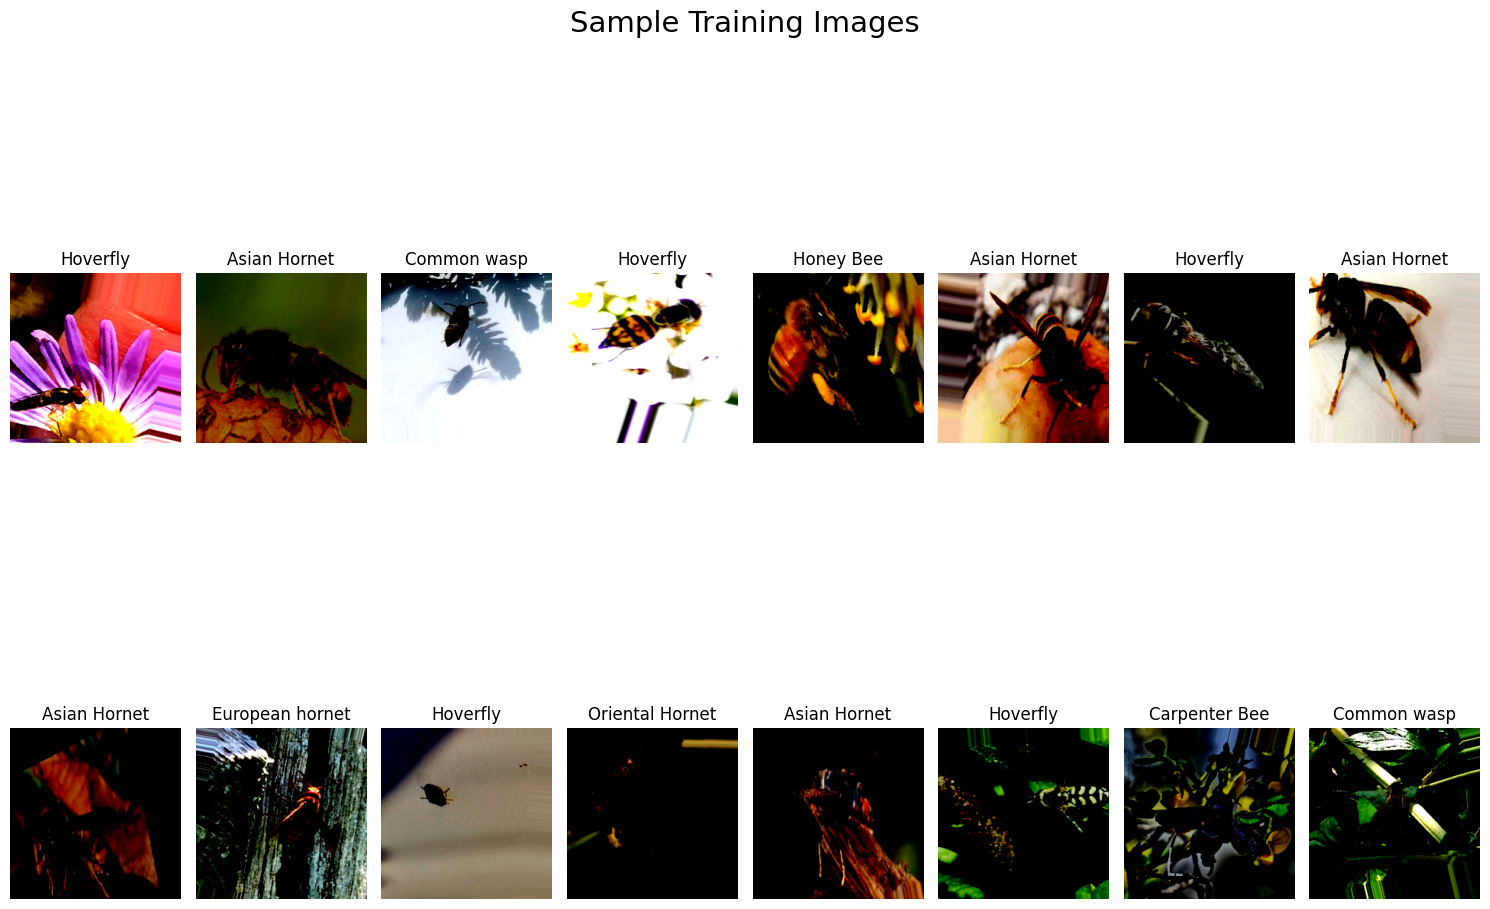

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,340,488 (8.93 MB)

 Trainable params: 2,306,376 (8.80 MB)

 Non-trainable params: 34,112 (133.25 KB)

None
Epoch 1/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 5496s 59s/step - accuracy: 0.2662 - loss: 2.0550 - val_accuracy: 0.5218 - val_loss: 1.3191 - learning_rate: 5.0000e-05
Epoch 2/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6105 - loss: 1.1376 - val_accuracy: 0.6452 - val_loss: 1.0042 - learning_rate: 5.0000e-05
Epoch 3/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.7554 - loss: 0.7417 - val_accuracy: 0.7103 - val_loss: 0.8225 - learning_rate: 5.0000e-05
Epoch 4/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8257 - loss: 0.5336 - val_accuracy: 0.7913 - val_loss: 0.5892 - learning_rate: 5.0000e-05
Epoch 5/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8642 - loss: 0.4167 - val_accuracy: 0.8242 - val_loss: 0.4908 - learning_rate: 5.0000e-05
Epoch 6/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.8843 - loss: 0.3468 - val_accuracy: 0.8545 - val_loss: 0.4003 - learning_rate: 5.0000e-05
Epoch 7/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 

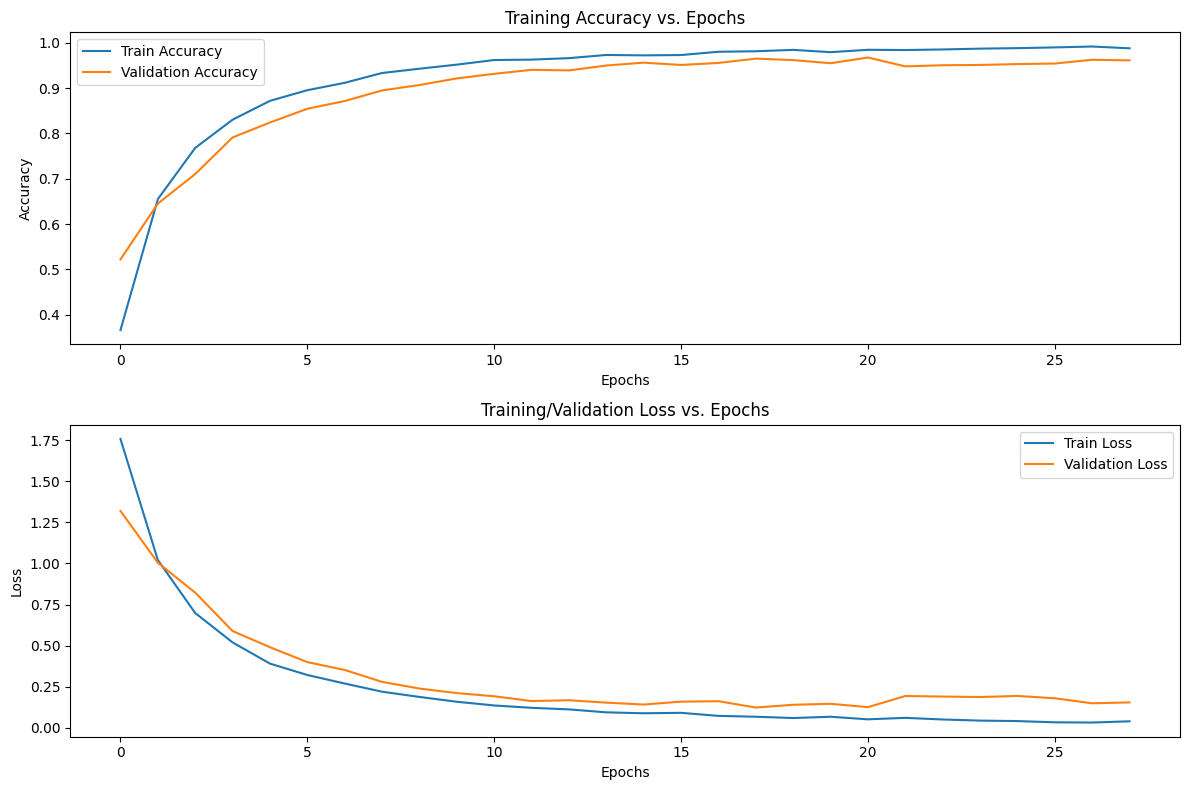

Found 797 images belonging to 8 classes.
13/13 - 600s - 46s/step - accuracy: 0.9661 - loss: 0.1263
Test Loss: 0.12627308070659637
Test Accuracy: 0.9661229848861694
13/13 - 11s - 873ms/step
Classification Report:
                      precision    recall  f1-score   support

       Asian Hornet       1.00      0.97      0.98       101
Asian giant Hornet        0.99      1.00      0.99        98
      Carpenter Bee       0.99      1.00      1.00       101
        Common wasp       0.95      0.88      0.91       101
    European hornet       0.98      1.00      0.99       101
          Honey Bee       0.99      0.94      0.96        93
           Hoverfly       0.86      0.94      0.90       101
    Oriental Hornet       0.98      1.00      0.99       101

           accuracy                           0.97       797
          macro avg       0.97      0.97      0.97       797
       weighted avg       0.97      0.97      0.97       797



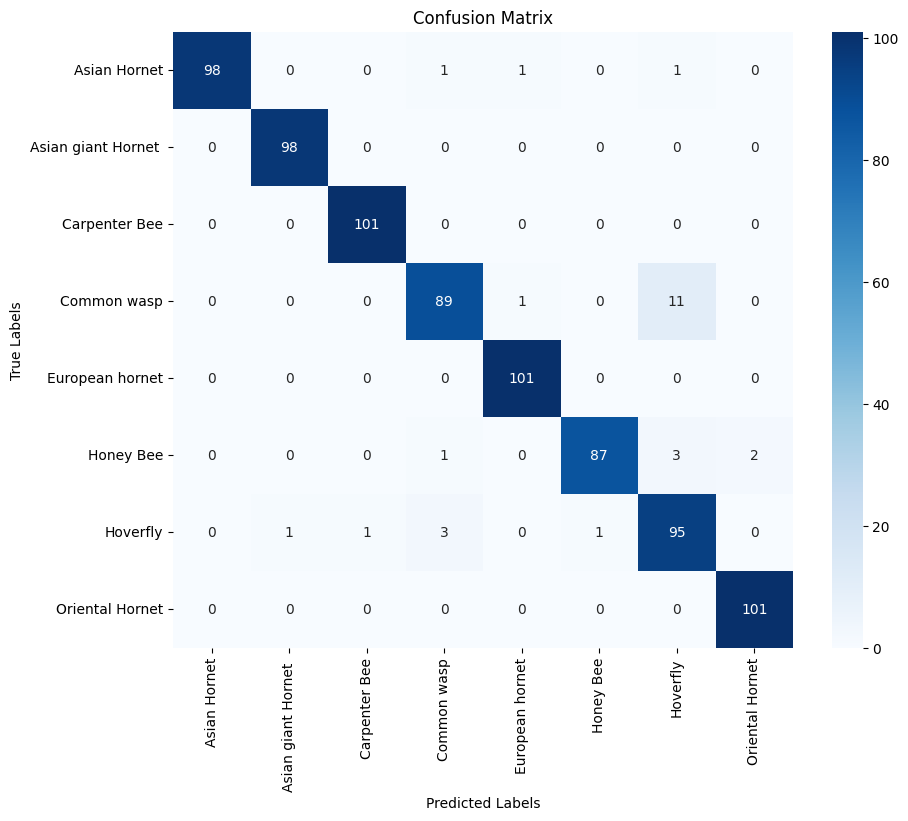

Final Training Accuracy: 98.81%
Final Validation Accuracy: 96.14%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Define directories
base_dir ='/content/drive/MyDrive/Insect Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, rotation_range=20,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest',
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=64,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                             target_size=(224, 224),
                                                             batch_size=64,
                                                             class_mode='categorical',
                                                             shuffle=True)

# Displaying Sample Images
labels = {value: key for key, value in train_generator.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(8):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# Model creation using MobileNetV2
def create_mobilenet_model(input_shape=(224, 224, 3), num_classes=8):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze the base model layers for fine-tuning
    for layer in base_model.layers:
        layer.trainable = True

    # Adding custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Create and summarize the model
mobilenet_model = create_mobilenet_model()
print(mobilenet_model.summary())

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('MobileNetV2.keras', monitor='val_loss', save_best_only=True)

# Compile the model
optimizer = Adam(learning_rate=0.00005)  # Lower learning rate for fine-tuning
mobilenet_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
history = mobilenet_model.fit(train_generator, epochs=90, validation_data=validation_generator,
                              verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Save the model
mobilenet_model.save('MobileNetV2_final.keras')

# Plot training results
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, '-', label='Train Accuracy')
ax[0].plot(val_accuracy, '-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, '-', label='Train Loss')
ax[1].plot(val_loss, '-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test data preparation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = mobilenet_model.evaluate(test_generator, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = mobilenet_model.predict(test_generator, verbose=2)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print final training and validation accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")


## EfficientNetB0

Found 5525 images belonging to 8 classes.
Found 1581 images belonging to 8 classes.
Label Mappings for classes present in the training and validation datasets

0 : Asian Hornet
1 : Asian giant Hornet 
2 : Carpenter Bee
3 : Common wasp
4 : European hornet
5 : Honey Bee
6 : Hoverfly
7 : Oriental Hornet


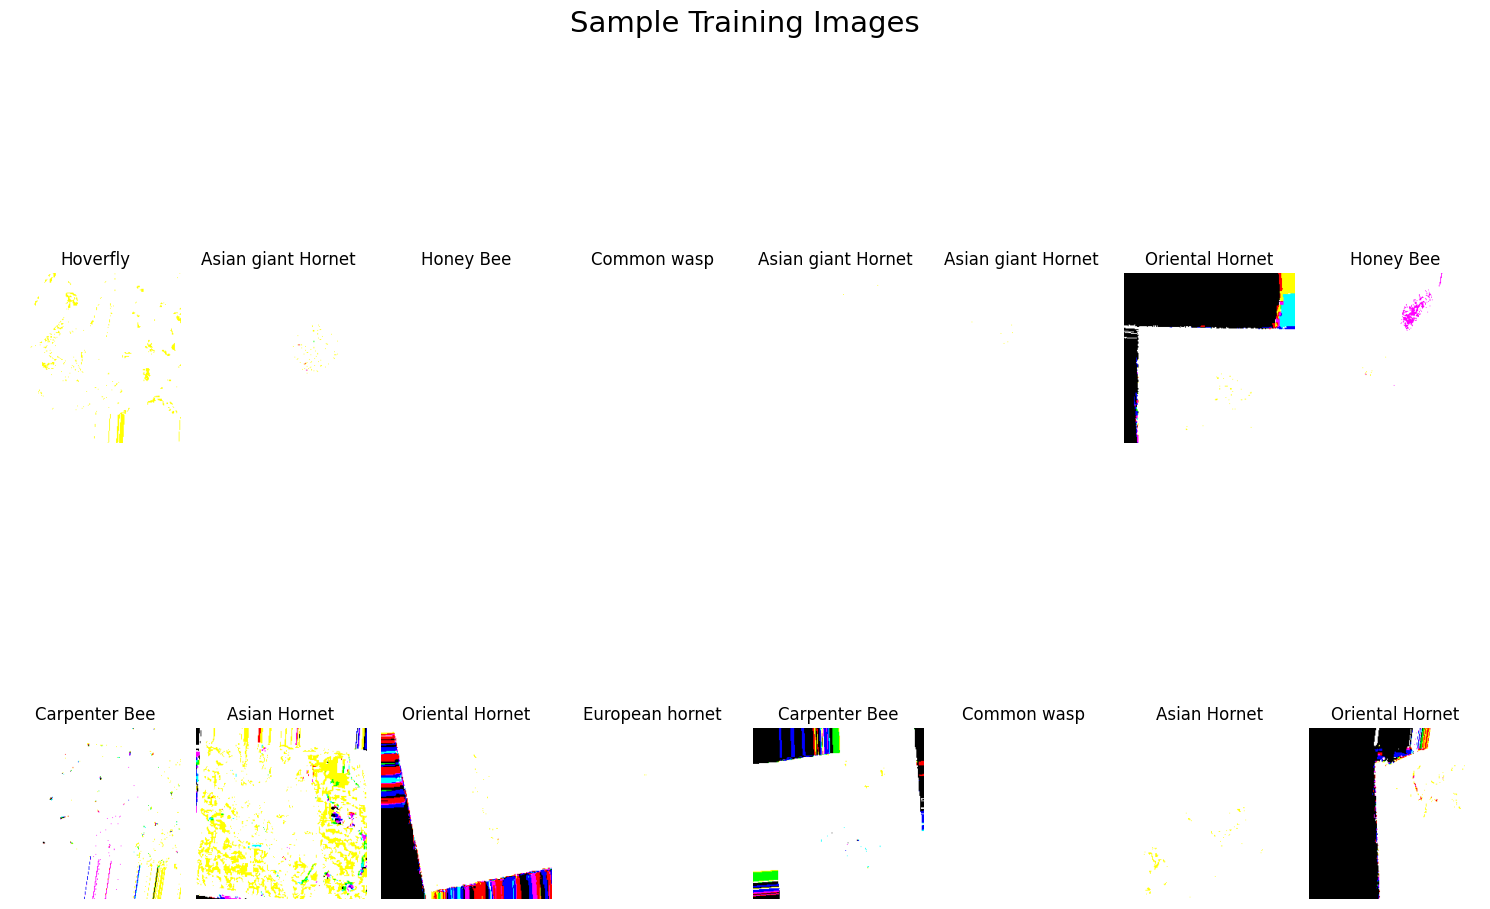

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,222,315 (16.11 MB)

 Trainable params: 4,180,292 (15.95 MB)

 Non-trainable params: 42,023 (164.16 KB)

None
Epoch 1/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.1555 - loss: 2.1168 - val_accuracy: 0.5560 - val_loss: 1.6518 - learning_rate: 1.0000e-04
Epoch 2/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.3727 - loss: 1.6777 - val_accuracy: 0.7432 - val_loss: 0.8860 - learning_rate: 1.0000e-04
Epoch 3/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5748 - loss: 1.1891 - val_accuracy: 0.8716 - val_loss: 0.4426 - learning_rate: 1.0000e-04
Epoch 4/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.7340 - loss: 0.8002 - val_accuracy: 0.8975 - val_loss: 0.3035 - learning_rate: 1.0000e-04
Epoch 5/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.7998 - loss: 0.6030 - val_accuracy: 0.9209 - val_loss: 0.2256 - learning_rate: 1.0000e-04
Epoch 6/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.8632 - loss: 0.4456 - val_accuracy: 0.9292 - val_loss: 0.2291 - learning_rate: 1.0000e-04
Epoch 7/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.

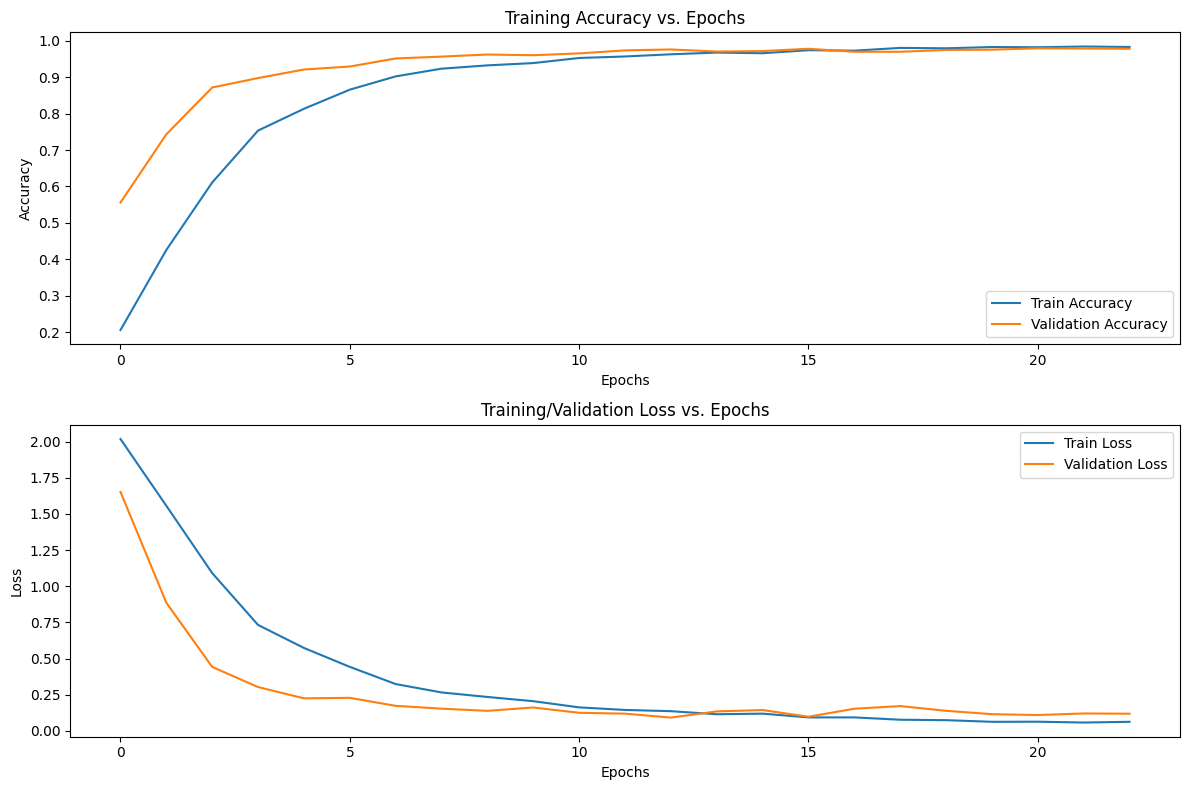

Found 797 images belonging to 8 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 893ms/step - accuracy: 0.9719 - loss: 0.1207
Test Loss: 0.13551411032676697
Test Accuracy: 0.962358832359314
13/13 - 17s - 1s/step
Classification Report:
                      precision    recall  f1-score   support

       Asian Hornet       0.99      0.99      0.99       101
Asian giant Hornet        1.00      0.97      0.98        98
      Carpenter Bee       0.97      1.00      0.99       101
        Common wasp       0.90      0.93      0.92       101
    European hornet       0.97      0.99      0.98       101
          Honey Bee       0.95      0.98      0.96        93
           Hoverfly       0.91      0.84      0.88       101
    Oriental Hornet       1.00      1.00      1.00       101

           accuracy                           0.96       797
          macro avg       0.96      0.96      0.96       797
       weighted avg       0.96      0.96      0.96       797



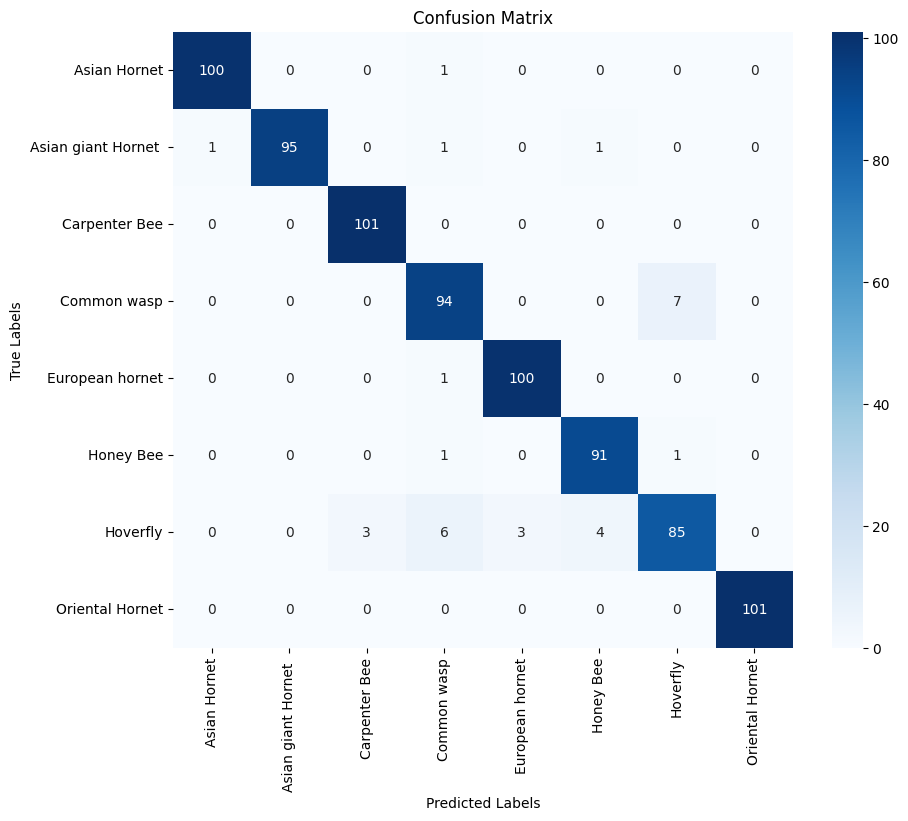

Final Training Accuracy: 98.28%
Final Validation Accuracy: 97.79%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# Define directories
base_dir = '/content/drive/MyDrive/Insect Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image Data Generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, rotation_range=20,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest',
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=64,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                             target_size=(224, 224),
                                                             batch_size=64,
                                                             class_mode='categorical',
                                                             shuffle=True)

# Labels mapping
labels = {value: key for key, value in train_generator.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

# Sample images
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(8):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# Model creation using EfficientNetB0
def create_efficientnet_model(input_shape=(224, 224, 3), num_classes=8):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freezing the base model layers
    for layer in base_model.layers:
        layer.trainable = True

    # Adding custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)  # First dense layer (128 neurons)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)   # Add a second dense layer (64 neurons)
    x = Dropout(0.5)(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Create and summarize the model
efficientnet_model = create_efficientnet_model()
print(efficientnet_model.summary())

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('EfficientNetB0.keras', monitor='val_loss', save_best_only=True)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
efficientnet_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model for 90 epochs with batch size of 64
history = efficientnet_model.fit(train_generator, epochs=90, validation_data=validation_generator,
                              verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Save the model
efficientnet_model.save('final_EfficientNetB0.keras')

# Plot training results
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, label='Train Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, label='Train Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test data preparation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = efficientnet_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = efficientnet_model.predict(test_generator, verbose=2)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print final training and validation accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")


## DenseNet121

Found 5525 images belonging to 8 classes.
Found 1581 images belonging to 8 classes.
Label Mappings for classes present in the training and validation datasets

0 : Asian Hornet
1 : Asian giant Hornet 
2 : Carpenter Bee
3 : Common wasp
4 : European hornet
5 : Honey Bee
6 : Hoverfly
7 : Oriental Hornet


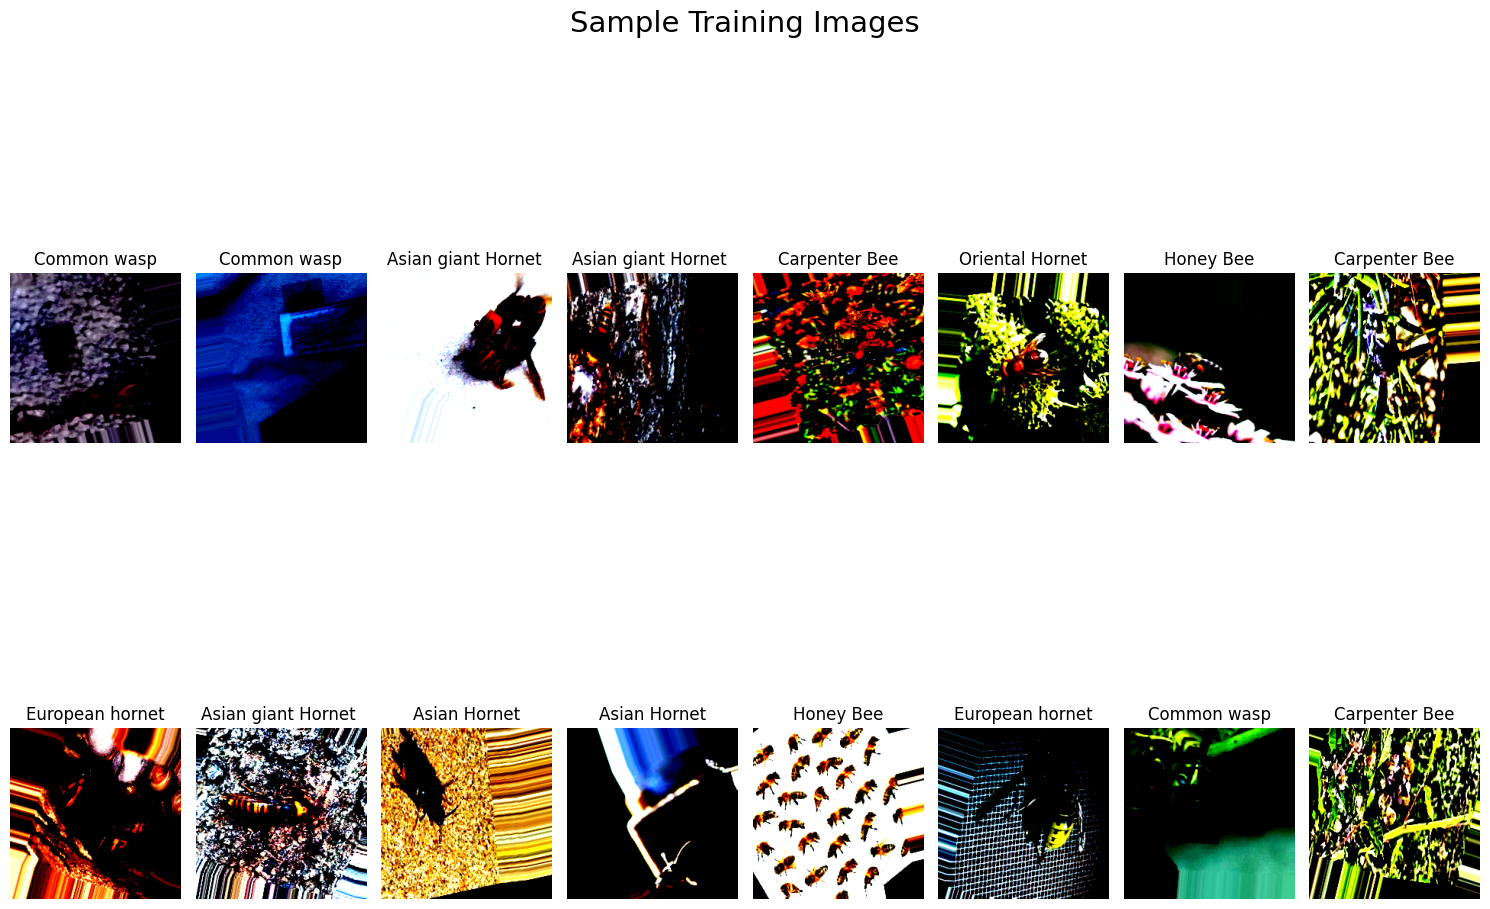

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,177,480 (27.38 MB)

 Trainable params: 7,093,832 (27.06 MB)

 Non-trainable params: 83,648 (326.75 KB)

None
Epoch 1/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 455s 3s/step - accuracy: 0.2127 - loss: 2.3343 - val_accuracy: 0.7476 - val_loss: 0.8344 - learning_rate: 1.0000e-04
Epoch 2/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.5526 - loss: 1.2111 - val_accuracy: 0.8874 - val_loss: 0.3855 - learning_rate: 1.0000e-04
Epoch 3/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7368 - loss: 0.7605 - val_accuracy: 0.9279 - val_loss: 0.2417 - learning_rate: 1.0000e-04
Epoch 4/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8398 - loss: 0.5068 - val_accuracy: 0.9380 - val_loss: 0.2015 - learning_rate: 1.0000e-04
Epoch 5/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8708 - loss: 0.3990 - val_accuracy: 0.9589 - val_loss: 0.1455 - learning_rate: 1.0000e-04
Epoch 6/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9101 - loss: 0.2866 - val_accuracy: 0.9235 - val_loss: 0.2376 - learning_rate: 1.0000e-04
Epoch 7/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.

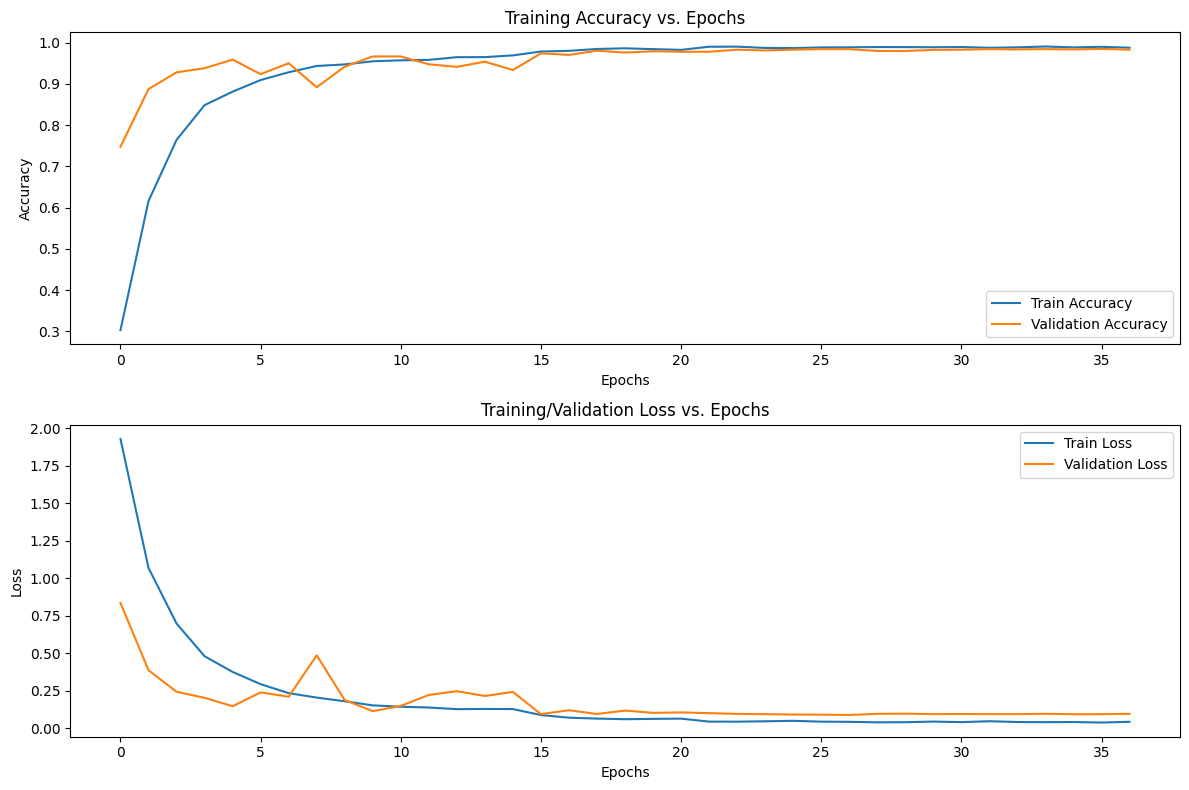

Found 797 images belonging to 8 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9781 - loss: 0.0949
Test Loss: 0.1343768835067749
Test Accuracy: 0.9736511707305908
13/13 - 22s - 2s/step
Classification Report:
                      precision    recall  f1-score   support

       Asian Hornet       0.99      0.99      0.99       101
Asian giant Hornet        1.00      1.00      1.00        98
      Carpenter Bee       1.00      0.98      0.99       101
        Common wasp       0.96      0.91      0.93       101
    European hornet       0.98      1.00      0.99       101
          Honey Bee       0.95      0.98      0.96        93
           Hoverfly       0.91      0.93      0.92       101
    Oriental Hornet       1.00      1.00      1.00       101

           accuracy                           0.97       797
          macro avg       0.97      0.97      0.97       797
       weighted avg       0.97      0.97      0.97       797



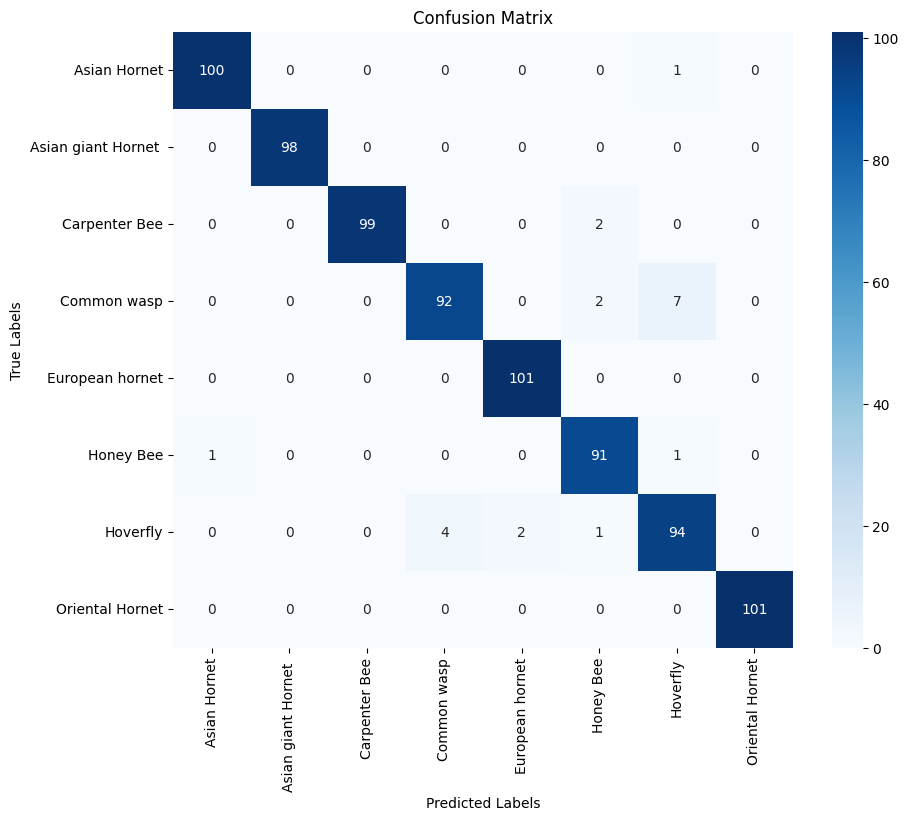

Final Training Accuracy: 98.77%
Final Validation Accuracy: 98.29%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

# Define directories
base_dir = '/content/drive/MyDrive/Insect Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image Data Generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, rotation_range=20,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest',
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=64,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                             target_size=(224, 224),
                                                             batch_size=64,
                                                             class_mode='categorical',
                                                             shuffle=True)

# Labels mapping
labels = {value: key for key, value in train_generator.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

# Sample images
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(8):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# Model creation using DenseNet121
def create_densenet_model(input_shape=(224, 224, 3), num_classes=8):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freezing the base model layers
    for layer in base_model.layers:
        layer.trainable = True

    # Adding custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)  # First dense layer (128 neurons)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)   # Add a second dense layer (64 neurons)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Create and summarize the model
densenet_model = create_densenet_model()
print(densenet_model.summary())

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('DenseNet121.keras', monitor='val_loss', save_best_only=True)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
densenet_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model for 90 epochs with batch size of 64
history = densenet_model.fit(train_generator, epochs=90, validation_data=validation_generator,
                              verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Save the model
densenet_model.save('final_DenseNet121.keras')

# Plot training results
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, label='Train Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, label='Train Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test data preparation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = densenet_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = densenet_model.predict(test_generator, verbose=2)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print final training and validation accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")


## InceptionV3

Found 5525 images belonging to 8 classes.
Found 1581 images belonging to 8 classes.
Label Mappings for classes present in the training and validation datasets

0 : Asian Hornet
1 : Asian giant Hornet 
2 : Carpenter Bee
3 : Common wasp
4 : European hornet
5 : Honey Bee
6 : Hoverfly
7 : Oriental Hornet


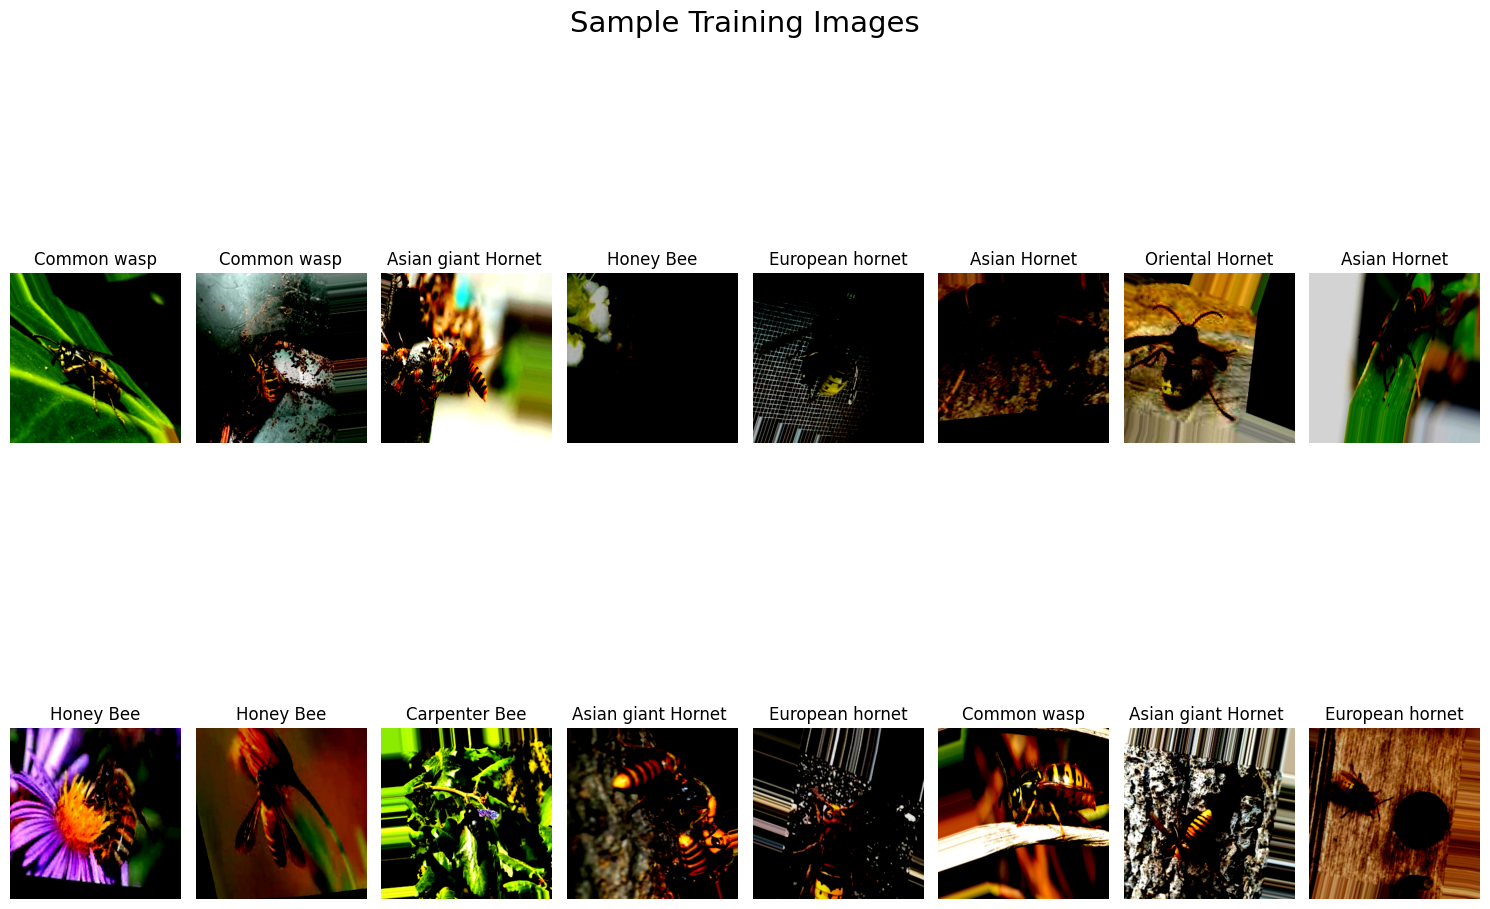

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,073,832 (84.20 MB)

 Trainable params: 22,039,400 (84.07 MB)

 Non-trainable params: 34,432 (134.50 KB)

None
Epoch 1/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 2668s 28s/step - accuracy: 0.2791 - loss: 1.9089 - val_accuracy: 0.7236 - val_loss: 0.8715 - learning_rate: 1.0000e-04
Epoch 2/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7169 - loss: 0.8289 - val_accuracy: 0.8805 - val_loss: 0.4183 - learning_rate: 1.0000e-04
Epoch 3/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8569 - loss: 0.4678 - val_accuracy: 0.9564 - val_loss: 0.1485 - learning_rate: 1.0000e-04
Epoch 4/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9043 - loss: 0.3184 - val_accuracy: 0.9367 - val_loss: 0.1948 - learning_rate: 1.0000e-04
Epoch 5/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9334 - loss: 0.2275 - val_accuracy: 0.9349 - val_loss: 0.2291 - learning_rate: 1.0000e-04
Epoch 6/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9457 - loss: 0.1973 - val_accuracy: 0.9545 - val_loss: 0.1890 - learning_rate: 1.0000e-04
Epoch 7/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 

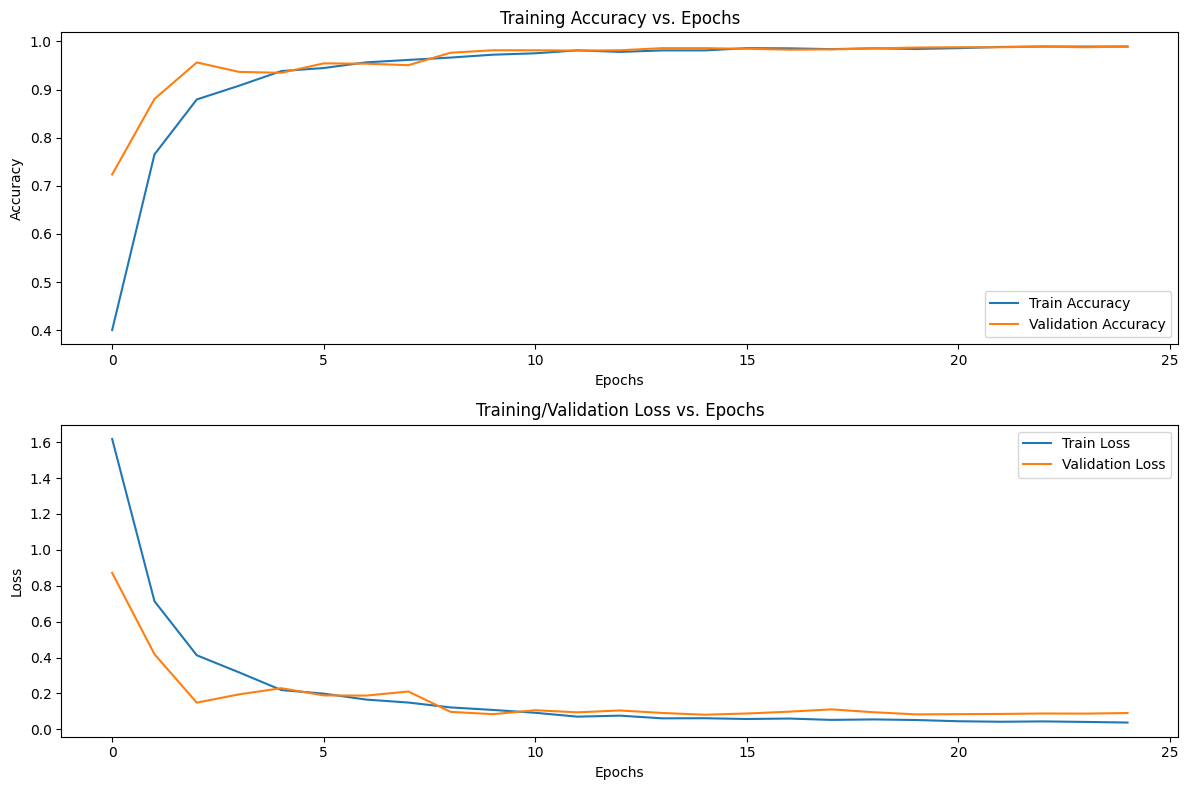

Found 797 images belonging to 8 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 277s 23s/step - accuracy: 0.9873 - loss: 0.0965
Test Loss: 0.10535071045160294
Test Accuracy: 0.9861982464790344
13/13 - 20s - 2s/step
Classification Report:
                      precision    recall  f1-score   support

       Asian Hornet       0.99      0.98      0.99       101
Asian giant Hornet        1.00      1.00      1.00        98
      Carpenter Bee       0.98      1.00      0.99       101
        Common wasp       0.95      0.98      0.97       101
    European hornet       1.00      1.00      1.00       101
          Honey Bee       1.00      0.99      0.99        93
           Hoverfly       0.98      0.94      0.96       101
    Oriental Hornet       0.99      1.00      1.00       101

           accuracy                           0.99       797
          macro avg       0.99      0.99      0.99       797
       weighted avg       0.99      0.99      0.99       797



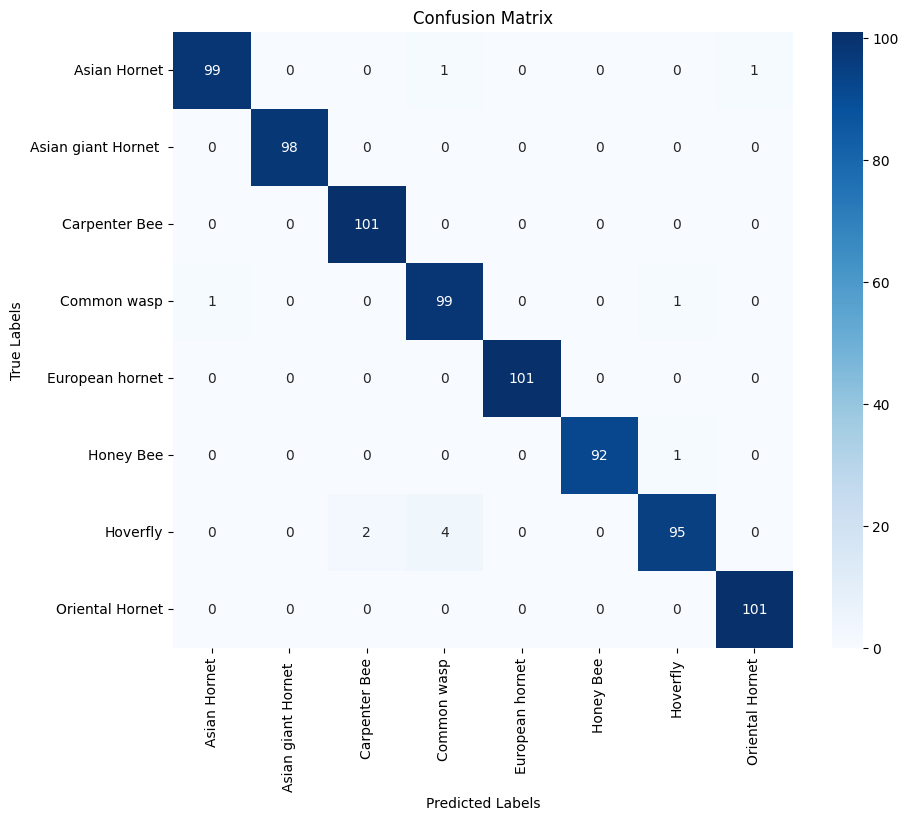

Final Training Accuracy: 98.95%
Final Validation Accuracy: 98.92%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Define directories
base_dir = '/content/drive/MyDrive/Insect Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image Data Generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, rotation_range=20,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest',
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(299, 299),
                                                   batch_size=64,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                             target_size=(299, 299),
                                                             batch_size=64,
                                                             class_mode='categorical',
                                                             shuffle=True)

# Labels mapping
labels = {value: key for key, value in train_generator.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

# Sample images
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(8):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# Model creation using InceptionV3
def create_inception_model(input_shape=(299, 299, 3), num_classes=8):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freezing the base model layers
    for layer in base_model.layers:
        layer.trainable = True

    # Adding custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)  # First dense layer (128 neurons)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)   # Add a second dense layer (64 neurons)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Create and summarize the model
inception_model = create_inception_model()
print(inception_model.summary())

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('InceptionV3.keras', monitor='val_loss', save_best_only=True)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
inception_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model for 90 epochs with batch size of 64
history = inception_model.fit(train_generator, epochs=90, validation_data=validation_generator,
                              verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Save the model
inception_model.save('final_inception_model_90epochs.keras')

# Plot training results
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, label='Train Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, label='Train Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test data preparation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(299, 299),
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = inception_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = inception_model.predict(test_generator, verbose=2)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print final training and validation accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")


## ResNet50

Found 5525 images belonging to 8 classes.
Found 1581 images belonging to 8 classes.
Label Mappings for classes present in the training and validation datasets

0 : Asian Hornet
1 : Asian giant Hornet 
2 : Carpenter Bee
3 : Common wasp
4 : European hornet
5 : Honey Bee
6 : Hoverfly
7 : Oriental Hornet


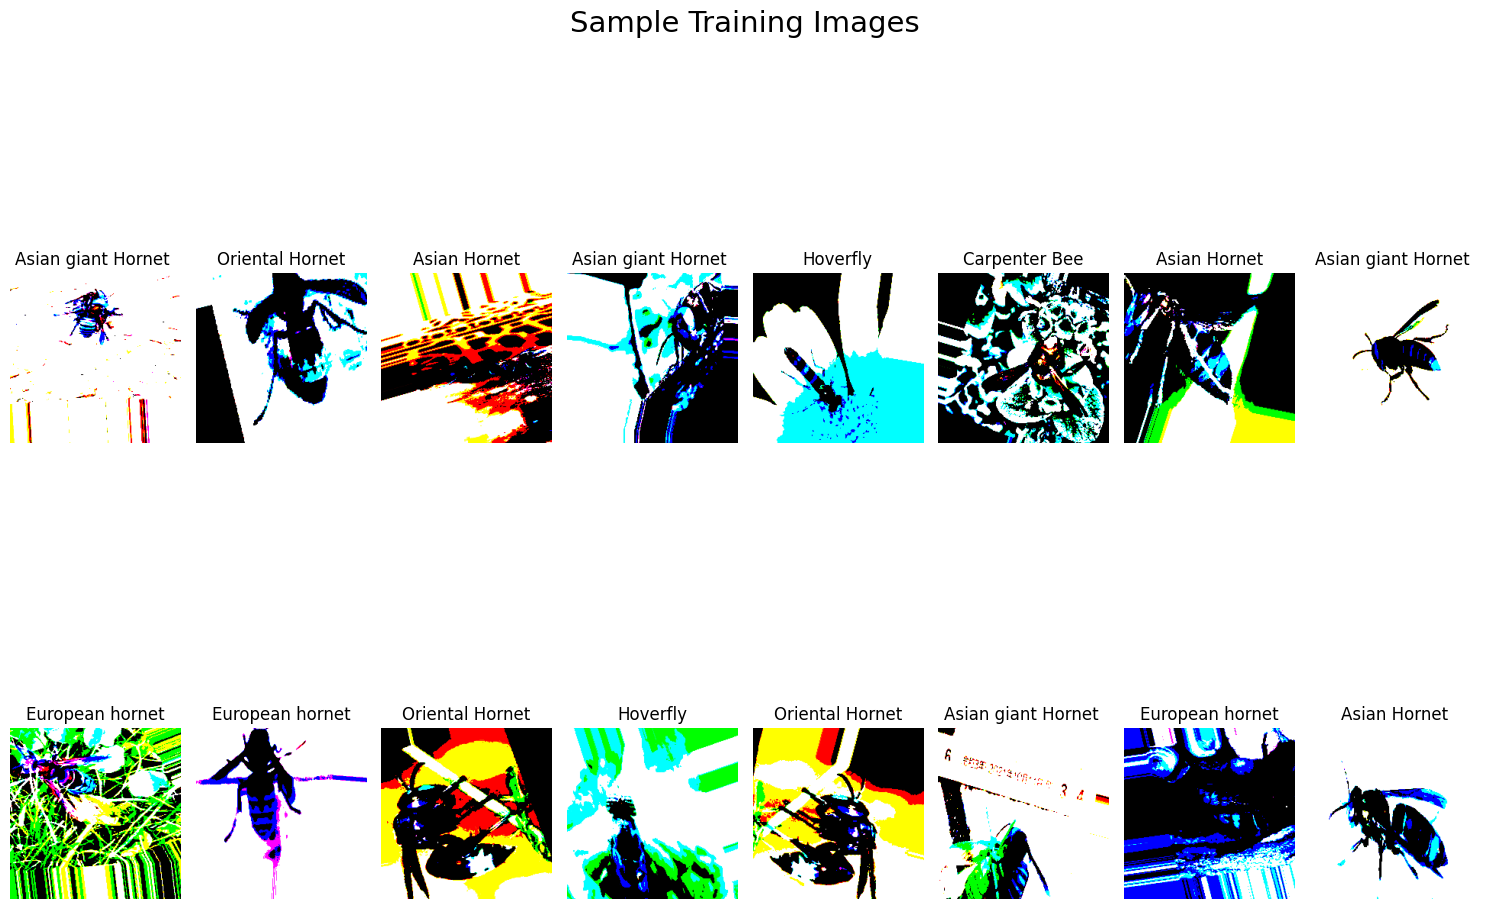

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,859,308 (91.02 MB)

 Trainable params: 23,806,188 (90.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

None
Epoch 1/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.2839 - loss: 1.9966 - val_accuracy: 0.8134 - val_loss: 0.5667 - learning_rate: 1.0000e-04
Epoch 2/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6977 - loss: 0.8657 - val_accuracy: 0.7704 - val_loss: 0.9845 - learning_rate: 1.0000e-04
Epoch 3/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8164 - loss: 0.5433 - val_accuracy: 0.9127 - val_loss: 0.2861 - learning_rate: 1.0000e-04
Epoch 4/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8794 - loss: 0.3968 - val_accuracy: 0.9228 - val_loss: 0.2720 - learning_rate: 1.0000e-04
Epoch 5/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9073 - loss: 0.3082 - val_accuracy: 0.9304 - val_loss: 0.2501 - learning_rate: 1.0000e-04
Epoch 6/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9145 - loss: 0.2693 - val_accuracy: 0.8817 - val_loss: 0.5273 - learning_rate: 1.0000e-04
Epoch 7/90
87/87 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.

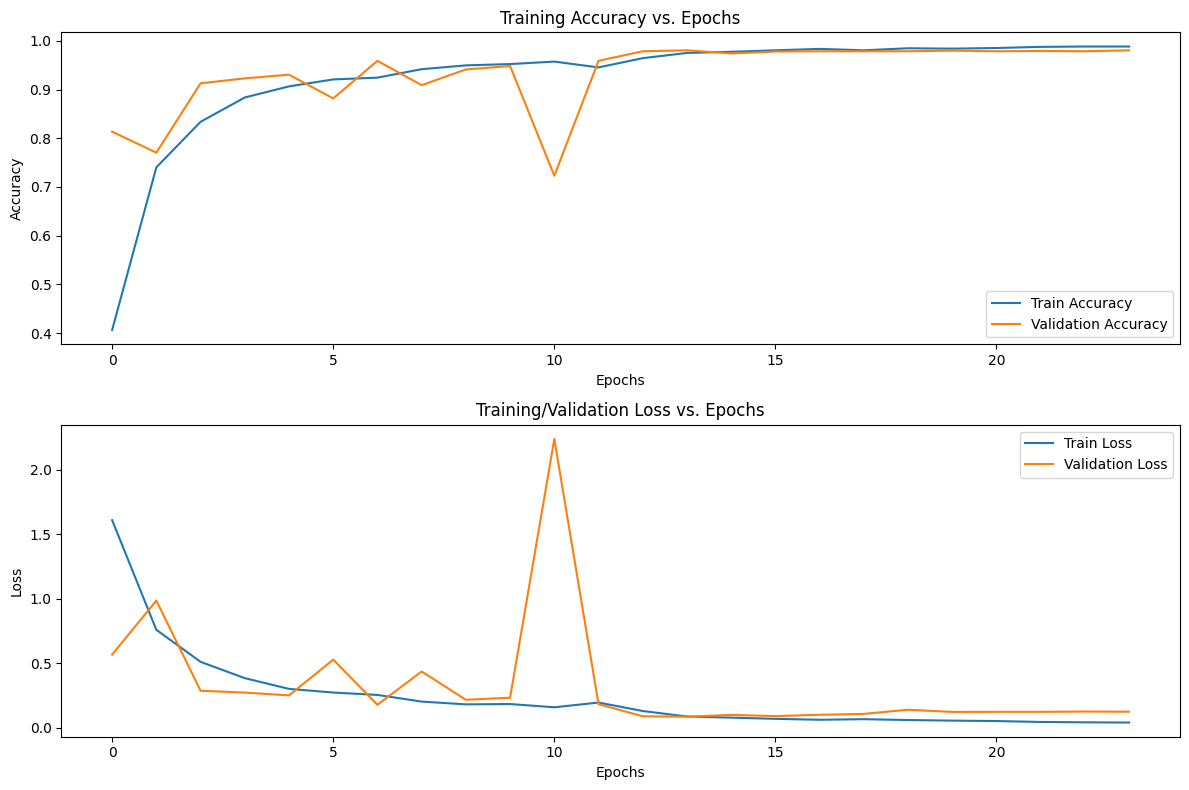

Found 797 images belonging to 8 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 805ms/step - accuracy: 0.9742 - loss: 0.0812
Test Loss: 0.09724531322717667
Test Accuracy: 0.9736511707305908
13/13 - 12s - 907ms/step
Classification Report:
                      precision    recall  f1-score   support

       Asian Hornet       0.97      0.98      0.98       101
Asian giant Hornet        1.00      0.98      0.99        98
      Carpenter Bee       0.99      0.99      0.99       101
        Common wasp       0.96      0.93      0.94       101
    European hornet       1.00      1.00      1.00       101
          Honey Bee       0.98      0.96      0.97        93
           Hoverfly       0.91      0.95      0.93       101
    Oriental Hornet       0.99      1.00      1.00       101

           accuracy                           0.97       797
          macro avg       0.97      0.97      0.97       797
       weighted avg       0.97      0.97      0.97       797



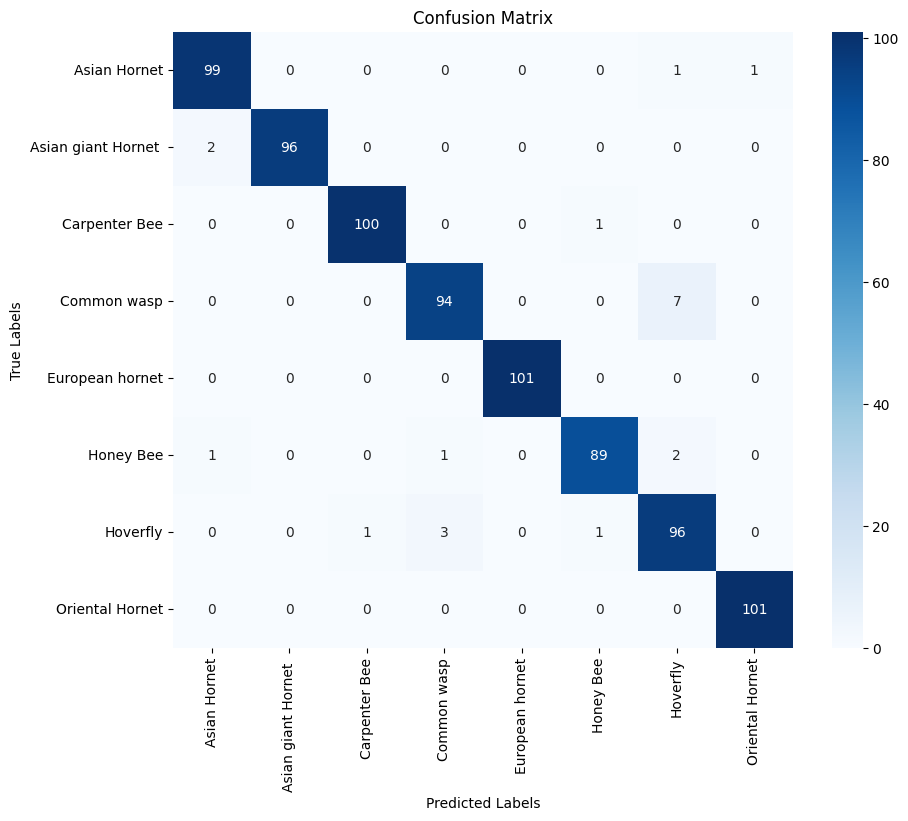

Final Training Accuracy: 98.82%
Final Validation Accuracy: 98.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define directories
base_dir = '/content/drive/MyDrive/Insect Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image Data Generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, rotation_range=20,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest',
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=64,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                             target_size=(224, 224),
                                                             batch_size=64,
                                                             class_mode='categorical',
                                                             shuffle=True)

# Labels mapping
labels = {value: key for key, value in train_generator.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

# Sample images
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(8):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()




# Model creation using ResNet50
def create_resnet_model(input_shape=(224, 224, 3), num_classes=8):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freezing the base model layers
    for layer in base_model.layers:
        layer.trainable = True

    # Adding custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(68, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Create and summarize the model
resnet_model = create_resnet_model()
print(resnet_model.summary())

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('ResNet50.keras', monitor='val_loss', save_best_only=True)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
resnet_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model for 90 epochs with batch size of 64
history = resnet_model.fit(train_generator, epochs=90, validation_data=validation_generator,
                              verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Save the model
resnet_model.save('final_ResNet50.keras')

# Plot training results
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, label='Train Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, label='Train Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Test data preparation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = resnet_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = resnet_model.predict(test_generator, verbose=2)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print final training and validation accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")
